In [2]:
%pip install openassetpricing

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
df_stock = pd.read_stata("Data/CRSP Universe Monthly Stock File 1960-2018.dta")

In [4]:
df_stock.columns

Index(['permno', 'date', 'nameendt', 'shrcd', 'exchcd', 'siccd', 'ncusip',
       'ticker', 'comnam', 'shrcls', 'tsymbol', 'naics', 'primexch', 'trdstat',
       'secstat', 'permco', 'issuno', 'hexcd', 'hsiccd', 'cusip', 'dclrdt',
       'dlamt', 'dlpdt', 'dlstcd', 'nextdt', 'paydt', 'rcrddt', 'shrflg',
       'hsicmg', 'hsicig', 'distcd', 'divamt', 'facpr', 'facshr', 'acperm',
       'accomp', 'shrenddt', 'nwperm', 'dlretx', 'dlprc', 'dlret', 'trtscd',
       'nmsind', 'mmcnt', 'nsdinx', 'bidlo', 'askhi', 'prc', 'vol', 'ret',
       'bid', 'ask', 'shrout', 'cfacpr', 'cfacshr', 'altprc', 'spread',
       'altprcdt', 'retx', 'vwretd', 'vwretx', 'ewretd', 'ewretx', 'sprtrn'],
      dtype='object')

In [5]:
df_stock['date'] = pd.to_datetime(df_stock["date"], format="%Y%m")
df_stock['date'] = df_stock['date'].dt.strftime('%Y-%m')


In [6]:
df_stock["permno"] = df_stock["permno"].astype(int)

In [136]:
import openassetpricing as oap

In [153]:
sales = openap.dl_signal('pandas', ['SALE'])



One or more input predictors are not available.

Data is downloaded: 0s


In [8]:
oap.list_release()

┌───────────┐
│   Release │
├───────────┤
│      2022 │
│      2023 │
│    202408 │
│    202410 │
└───────────┘


In [138]:
openap = oap.OpenAP(202410)

In [10]:
df_bm = openap.dl_signal('pandas', ['BM'])


Data is downloaded: 14s


In [11]:

df_bm["date"] = pd.to_datetime(df_bm["yyyymm"].astype(str), format='%Y%m')
df_bm["date"] = df_bm["date"].dt.strftime("%Y-%m")

In [12]:
df = pd.merge(df_stock, df_bm, left_on=["permno", "date"], right_on=["permno", "date"], how="inner")

„Beobachtungen mit einem cfacpr- oder cfacshr-Wert von 0 wurden im Rahmen der Datenbereinigung auf den Wert 1 gesetzt. Dies erfolgt unter der Annahme, dass in diesen Fällen keine Kapitalmaßnahmen vorlagen, die eine Preis- oder Stückzahladjustierung erforderlich gemacht hätten.“

In [13]:
df['cfacpr'] = df['cfacpr'].replace(0, 1)
df['cfacshr'] = df['cfacshr'].replace(0, 1)

df["adj_price"] = df["altprc"].abs() / df["cfacpr"]
df["adj_shrout"] = df["shrout"] * df["cfacshr"]
df["adj_dividend"] = df["divamt"] / df["cfacpr"]

In [80]:
df[df['cfacpr'] == 0][['permno', 'date', 'prc', 'cfacpr']]


,permno,date,prc,cfacpr


In [3]:
df = pd.read_pickle('Data/crsp-data.pkl')

Vorgehen

- log returns berechnen
- log(Pt+/Bt+) - log(Pt-1/Bt-1)  --> Change in aggregate valuation
- log(Bt-/Bt-1) - log(Dt-/Pt-)   --> Income Yield
- log(Pt-/Bt-) - log(Pt+/Bt+)    --> Migration

Price --> altprc


Probleme

- Werte Pt- und Bt- korrekt zu bestimmen!

Here’s a breakdown of the columns you've listed from the CRSP stock data:

permno:
Description: Unique permanent identifier for each stock in the CRSP database.
Type: Integer.
date:
Description: The date for the data point (typically monthly).
Type: DateTime (monthly).
nameendt:
Description: The end date for the stock's name (can be relevant for name changes).
Type: DateTime.
shrcd:
Description: Share code that identifies the type of shares (e.g., common, preferred).
Type: Integer.
exchcd:
Description: Exchange code (e.g., NYSE, NASDAQ).
Type: Integer.
siccd:
Description: Standard Industrial Classification code, representing the industry of the firm.
Type: Integer.
ncusip:
Description: The company's CUSIP identifier (unique identifier for the company).
Type: String.
ticker:
Description: Ticker symbol used for stock trading.
Type: String.
comnam:
Description: Company name.
Type: String.
shrcls:
Description: Share class code (indicating different types of shares).
Type: Integer.
tsymbol:
Description: Stock's trading symbol.
Type: String.
naics:
Description: North American Industry Classification System code.
Type: Integer.
primexch:
Description: The primary exchange where the stock is listed.
Type: Integer.
trdstat:
Description: Trading status (active, inactive, etc.).
Type: Integer.
secstat:
Description: Security status (e.g., listed, delisted).
Type: Integer.
permco:
Description: Unique identifier for the company (distinct from permno, which is stock-specific).
Type: Integer.
issuno:
Description: The number of the issue (different from the company, which might have multiple issues).
Type: Integer.
hexcd:
Description: The exchange code for the stock.
Type: Integer.
hsiccd:
Description: A code that categorizes the industry sector (from SIC codes).
Type: Integer.
cusip:
Description: CUSIP identifier for the stock.
Type: String.
dclrdt:
Description: The date the dividend was declared.
Type: DateTime.
dlamt:
Description: The dividend amount declared.
Type: Float.
dlpdt:
Description: The date the dividend was paid.
Type: DateTime.
dlstcd:
Description: The code for the dividend status (paid, etc.).
Type: Integer.
nextdt:
Description: The date for the next dividend or relevant corporate action.
Type: DateTime.
paydt:
Description: The payment date for dividends.
Type: DateTime.
rcrddt:
Description: The record date for the dividend or corporate action.
Type: DateTime.
shrflg:
Description: Flag indicating the share structure (e.g., class of shares).
Type: Integer.
hsicmg:
Description: A code for the industry category (HSIC) of the stock.
Type: Integer.
hsicig:
Description: A code for the industry classification group (HSIC).
Type: Integer.
distcd:
Description: Distribution code (can be for dividends or other actions).
Type: Integer.
divamt:
Description: The amount of dividend paid.
Type: Float.
facpr:
Description: The factor for price adjustment (often for stock splits).
Type: Float.
facshr:
Description: The factor for share adjustment (e.g., stock splits).
Type: Float.
acperm:
Description: The company’s permanent ID (used for mergers and acquisitions).
Type: Integer.
accomp:
Description: The company ID after a merger or acquisition.
Type: Integer.
shrenddt:
Description: The end date of the stock’s share class or listing.
Type: DateTime.
nwperm:
Description: The new permanent identifier after a corporate change.
Type: Integer.
dlretx:
Description: The total return of the stock, including dividends.
Type: Float.
dlprc:
Description: The price of the stock after adjustments (e.g., for splits).
Type: Float.
dlret:
Description: The price return of the stock excluding dividends.
Type: Float.
trtscd:
Description: A code for the stock's trading status (active, delisted, etc.).
Type: Integer.
nmsind:
Description: Industry sector indicator.
Type: Integer.
mmcnt:
Description: Market maker count.
Type: Integer.
nsdinx:
Description: The index status for the stock (for index inclusion).
Type: Integer.
bidlo:
Description: The lowest bid price of the stock.
Type: Float.
askhi:
Description: The highest ask price of the stock.
Type: Float.
prc:
Description: The price of the stock.
Type: Float.
vol:
Description: The trading volume of the stock.
Type: Integer.
ret:
Description: The simple return of the stock.
Type: Float.
bid:
Description: The bid price of the stock.
Type: Float.
ask:
Description: The ask price of the stock.
Type: Float.
shrout:
Description: The number of outstanding shares for the stock.
Type: Integer.
cfacpr:
Description: The factor for price adjustment (such as for stock splits).
Type: Float.
cfacshr:
Description: The factor for share adjustment (such as for stock splits).
Type: Float.
altprc:
Description: Alternative price for the stock (may represent a different pricing source).
Type: Float.
spread:
Description: The bid-ask spread.
Type: Float.
altprcdt:
Description: The date of the alternative price.
Type: DateTime.
retx:
Description: The total return of the stock, including dividends, with a different computation or adjustments.
Type: Float.
vwretd:
Description: Value-weighted return of the stock index.
Type: Float.

In [16]:
df = df.drop_duplicates(subset=["date", "permno"], keep="first")
duplicates = df[df.duplicated(subset=['date', 'permno'], keep=False)]
print(duplicates)


Empty DataFrame
Columns: [permno, date, nameendt, shrcd, exchcd, siccd, ncusip, ticker, comnam, shrcls, tsymbol, naics, primexch, trdstat, secstat, permco, issuno, hexcd, hsiccd, cusip, dclrdt, dlamt, dlpdt, dlstcd, nextdt, paydt, rcrddt, shrflg, hsicmg, hsicig, distcd, divamt, facpr, facshr, acperm, accomp, shrenddt, nwperm, dlretx, dlprc, dlret, trtscd, nmsind, mmcnt, nsdinx, bidlo, askhi, prc, vol, ret, bid, ask, shrout, cfacpr, cfacshr, altprc, spread, altprcdt, retx, vwretd, vwretx, ewretd, ewretx, sprtrn, yyyymm, BM, adj_price, adj_shrout, adj_dividend]
Index: []

[0 rows x 69 columns]


In [169]:
pd.to_pickle(df, 'crsp-data.pkl')

In [168]:
df

,permno,date,nameendt,shrcd,exchcd,siccd,ncusip,ticker,comnam,shrcls,...,sprtrn,yyyymm,BM,adj_price,adj_shrout,adj_dividend,market_equity,book_equity,log_ret,fiscal_year
0,10000,1987-04-01,NaT,10.0,3.0,3990.0,68391610,OMFGA,OPTIMUM MANUFACTURING INC,A,...,-0.011450,198704,-2.895161,0.234375,3893.0,NaN,9.124219e+05,5.044793e+04,-0.064539,1986
1,10000,1987-05-01,NaT,10.0,3.0,3990.0,68391610,OMFGA,OPTIMUM MANUFACTURING INC,A,...,0.006034,198705,-2.895161,0.218750,3893.0,NaN,8.515938e+05,4.708474e+04,-0.068993,1986
2,10001,1986-12-01,NaT,11.0,3.0,4920.0,39040610,GFGC,GREAT FALLS GAS CO,,...,-0.028288,198612,-0.104958,2.333333,2973.0,0.035,6.937000e+06,6.245815e+06,0.014889,1986
3,10001,1987-01-01,NaT,11.0,3.0,4920.0,39040610,GFGC,GREAT FALLS GAS CO,,...,0.131767,198701,-0.104958,2.250000,2973.0,NaN,6.689250e+06,6.022751e+06,-0.036368,1986
4,10001,1987-02-01,NaT,11.0,3.0,4920.0,39040610,GFGC,GREAT FALLS GAS CO,,...,0.036924,198702,-0.104958,2.083333,2973.0,NaN,6.193750e+06,5.576621e+06,-0.076961,1986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466395,93436,2018-08-01,NaT,11.0,3.0,9999.0,88160R10,TSLA,TESLA INC,,...,0.030263,201808,-2.622768,301.660004,170593.0,NaN,5.146109e+10,3.736157e+09,0.011737,2018
2466396,93436,2018-09-01,NaT,11.0,3.0,9999.0,88160R10,TSLA,TESLA INC,,...,0.004294,201809,-2.622768,264.769989,171578.0,NaN,4.542871e+10,3.298196e+09,-0.130439,2018
2466397,93436,2018-10-01,NaT,11.0,3.0,9999.0,88160R10,TSLA,TESLA INC,,...,-0.069403,201810,-2.622768,337.320007,171733.0,NaN,5.792898e+10,4.205736e+09,0.242171,2018
2466398,93436,2018-11-01,NaT,11.0,3.0,9999.0,88160R10,TSLA,TESLA INC,,...,0.017859,201811,-2.622768,350.480011,171733.0,NaN,6.018898e+10,4.369816e+09,0.038272,2018


In [6]:
#Returns computation
returns = df.pivot(index="date", columns="permno", values="ret")
returns.index = pd.to_datetime(returns.index)
returns.index = returns.index.to_period("M")
returns.head()

permno,10000,10001,10002,10003,10005,10006,10007,10008,10009,10010,...,93422,93426,93427,93428,93429,93432,93433,93434,93435,93436
date,,,,,,,,,,,,,,,,,,,,,
1960-01,NaN,NaN,NaN,NaN,NaN,0.005155,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-02,NaN,NaN,NaN,NaN,NaN,0.046154,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-03,NaN,NaN,NaN,NaN,NaN,-0.059553,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-04,NaN,NaN,NaN,NaN,NaN,-0.081794,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-05,NaN,NaN,NaN,NaN,NaN,0.048851,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
#Dividends computation
dividends = df.pivot(index="date", columns="permno", values="adj_dividend")
dividends.index = dividends.index.to_period("M")
#pd.to_pickle(dividends, "dividends.pkl")

In [8]:
#Book Value computation

# Market Equity = price * shares outstanding
df['market_equity'] = df['adj_price'] * df['adj_shrout'] * 1000  # in dollars

# Book Equity = Market Equity × (Book-to-Market)
df['book_equity'] = df['market_equity'] * np.exp(df['BM'])
df.head()

,permno,date,nameendt,shrcd,exchcd,siccd,ncusip,ticker,comnam,shrcls,...,sprtrn,yyyymm,BM,adj_price,adj_shrout,adj_dividend,market_equity,book_equity,log_ret,fiscal_year
0,10000,1987-04-01,NaT,10.0,3.0,3990.0,68391610,OMFGA,OPTIMUM MANUFACTURING INC,A,...,-0.011450,198704,-2.895161,0.234375,3893.0,NaN,912421.875,5.044793e+04,-0.064539,1986
1,10000,1987-05-01,NaT,10.0,3.0,3990.0,68391610,OMFGA,OPTIMUM MANUFACTURING INC,A,...,0.006034,198705,-2.895161,0.218750,3893.0,NaN,851593.750,4.708474e+04,-0.068993,1986
2,10001,1986-12-01,NaT,11.0,3.0,4920.0,39040610,GFGC,GREAT FALLS GAS CO,,...,-0.028288,198612,-0.104958,2.333333,2973.0,0.035,6937000.000,6.245815e+06,0.014889,1986
3,10001,1987-01-01,NaT,11.0,3.0,4920.0,39040610,GFGC,GREAT FALLS GAS CO,,...,0.131767,198701,-0.104958,2.250000,2973.0,NaN,6689250.000,6.022751e+06,-0.036368,1986
4,10001,1987-02-01,NaT,11.0,3.0,4920.0,39040610,GFGC,GREAT FALLS GAS CO,,...,0.036924,198702,-0.104958,2.083333,2973.0,NaN,6193750.000,5.576621e+06,-0.076961,1986


In [21]:
# Ensure 'date' is datetime
df['date'] = pd.to_datetime(df['date'])

# Convert returns to numeric, set invalid entries (e.g. 'C', 'B') to NaN
df['ret'] = pd.to_numeric(df['ret'], errors='coerce')

# Drop rows with missing returns
df = df.dropna(subset=['ret'])

# Compute monthly log returns
df['log_ret'] = np.log1p(df['ret'])  # log(1 + ret)

# Adjust fiscal year to run from June to May
# Fiscal year starts in June; if the month is before June, assign it to the previous year
df['fiscal_year'] = df['date'].dt.year.where(df['date'].dt.month >= 6, df['date'].dt.year - 1)

# Group by fiscal year and permno
def annualized_log_return(x):
    n = len(x)
    if n >= 9:  # Make sure we have at least 9 months of data for the fiscal year
        return x.sum() * (12 / n)  # Annualize if we have less than 12 months of data
    else:
        return np.nan

# Apply and reshape to get portfolio-level data
annual_log_returns = df.groupby(['fiscal_year', 'permno'])['log_ret'].apply(annualized_log_return).unstack('permno')
annual_log_returns.index = pd.to_datetime(annual_log_returns.index.astype(str) + "-06")
annual_log_returns.index = annual_log_returns.index.to_period("M")
annual_log_returns.head()

permno,10000,10001,10002,10003,10005,10006,10007,10008,10009,10010,...,93422,93426,93427,93428,93429,93432,93433,93434,93435,93436
fiscal_year,,,,,,,,,,,,,,,,,,,,,
1959-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-06,NaN,NaN,NaN,NaN,NaN,0.337212,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961-06,NaN,NaN,NaN,NaN,NaN,0.039382,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-06,NaN,NaN,NaN,NaN,NaN,0.517020,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-06,NaN,NaN,NaN,NaN,NaN,0.360593,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
bm = df.pivot(index="date", columns="permno", values="BM")
bm.index = pd.to_datetime(bm.index, format="ISO8601")
bm_dec = bm[bm.index.month == 10]
bm_dec

#pd.to_pickle(bm_dec, 'bm_dec.pkl')

permno,10000,10001,10002,10003,10005,10006,10007,10008,10009,10010,...,93422,93426,93427,93428,93429,93432,93433,93434,93435,93436
date,,,,,,,,,,,,,,,,,,,,,
1960-10-01,NaN,NaN,NaN,NaN,NaN,0.657796,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961-10-01,NaN,NaN,NaN,NaN,NaN,0.401820,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-10-01,NaN,NaN,NaN,NaN,NaN,0.180738,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-10-01,NaN,NaN,NaN,NaN,NaN,-0.011987,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1964-10-01,NaN,NaN,NaN,NaN,NaN,-0.384125,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-10-01,NaN,NaN,NaN,NaN,NaN,-0.568076,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1966-10-01,NaN,NaN,NaN,NaN,NaN,-0.531412,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1967-10-01,NaN,NaN,NaN,NaN,NaN,-0.502190,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1968-10-01,NaN,NaN,NaN,NaN,NaN,-0.408588,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
#Bookvalue Pivot
bookvalue = df.pivot(index="date", columns="permno", values="book_equity")
#bookvalue.index = pd.to_datetime(bookvalue.index).strftime("%Y-%m")
bookvalue.index = bookvalue.index.to_period("M")
#pd.to_pickle(bookvalue, 'bookvalue.pkl')

In [11]:
price = df.pivot(index="date", columns="permno", values="adj_price")
#price.index = pd.to_datetime(price.index).strftime("%Y-%m")
price.index = price.index.to_period("M")
#price.abs()
#pd.to_pickle(price, 'price.pkl')

In [12]:
shrout = df.pivot(index="date", columns="permno", values="adj_shrout")
shrout.index = shrout.index.to_period("M")
shrout.head()
#pd.to_pickle(shrout, 'shrout.pkl')

permno,10000,10001,10002,10003,10005,10006,10007,10008,10009,10010,...,93422,93426,93427,93428,93429,93432,93433,93434,93435,93436
date,,,,,,,,,,,,,,,,,,,,,
1960-01,NaN,NaN,NaN,NaN,NaN,8508.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-02,NaN,NaN,NaN,NaN,NaN,8508.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-03,NaN,NaN,NaN,NaN,NaN,8508.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-04,NaN,NaN,NaN,NaN,NaN,8508.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-05,NaN,NaN,NaN,NaN,NaN,8508.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
hsiccd_data = df.pivot(index='date', columns='permno', values='hsiccd')
hsiccd_data.index = hsiccd_data.index.to_period('M')
hsiccd_data.head()

permno,10000,10001,10002,10003,10005,10006,10007,10008,10009,10010,...,93422,93426,93427,93428,93429,93432,93433,93434,93435,93436
date,,,,,,,,,,,,,,,,,,,,,
1960-01,NaN,NaN,NaN,NaN,NaN,3743.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-02,NaN,NaN,NaN,NaN,NaN,3743.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-03,NaN,NaN,NaN,NaN,NaN,3743.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-04,NaN,NaN,NaN,NaN,NaN,3743.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-05,NaN,NaN,NaN,NaN,NaN,3743.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
#pd.to_pickle(bm, "bm.pkl")
#pd.to_pickle(bm_june, "bm_june.pkl")
#pd.to_pickle(df, "df.pkl")
#pd.to_pickle(df_stock, "df_stock.pkl")
#pd.to_pickle(returns, "returns.pkl")
#pd.to_pickle(df_bm, "df_bm.pkl")
#pd.to_pickle(annual_log_returns, "annual_log_returns.pkl")
#pd.to_pickle(dividends, "dividends.pkl")
#pd.to_pickle(bookvalue, "bookvalue.pkl")
#pd.to_pickle(price, "price.pkl")
#pd.to_pickle(shrout, "shrout.pkl")
#pd.to_pickle(market_cap, "market_cap.pkl")

In [27]:
pd.to_pickle(df, 'crsp.pkl')

Portfolio Construction:
Openassetpricing provides BM data in the following structure: monthly data, changed in the december of the prior year. therefore the BM ratio at the time of portfolio construction (End of June in every year) can be used without any timeshifts.

Delisting returns?

This is year:  1961
This is year (bottom):  1961


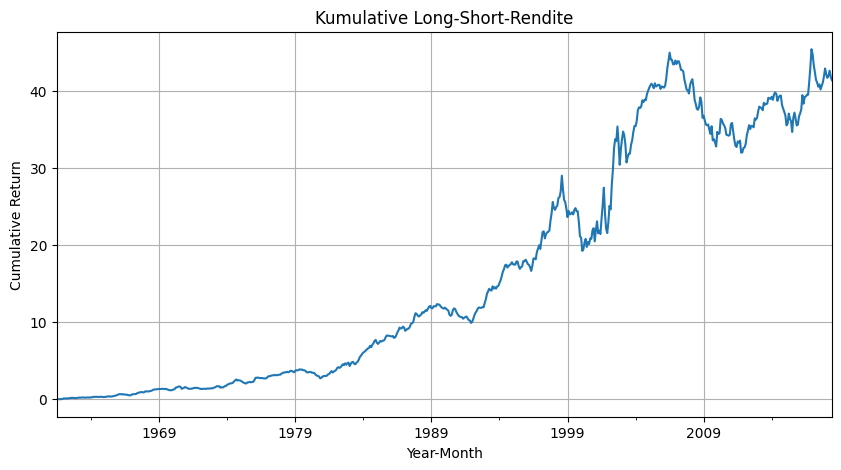

In [64]:
#Value Weighted Portfolio
long_short_returns = []
bm_dec.index = pd.to_datetime(bm_dec.index, format="%Y-%m")
#returns.index = pd.to_datetime(returns.index)
#returns.index = returns.index.to_period("M")
log_returns = []

price_long_ts = []
dividends_long_ts = []
bookvalue_long_ts = []
price_minus_long_ts = []
bookvalue_minus_long_ts = []
dividends_m_long_ts = []
dividends_m_short_ts = []
long_log_returns = []

price_short_ts = []
dividends_short_ts = []
bookvalue_short_ts = []
price_minus_short_ts = []
bookvalue_minus_short_ts = []
short_log_returns = []

portfolio_value_long = []
portfolio_value_short = []

top_permno_all = []
bottom_permno_all = []

top_permnos = []
bottom_permnos = []

long_ret = []
pb_long = []
pb_short = []
bv_pershare_short = []

ann_ret_long = []
ann_ret_short = []

price_minus_long_monthly = []
price_minus_short_monthly = []

bookvalue_minus_long_monthly = []
bookvalue_minus_short_monthly = []
bookvalue_long_monthly = []
bookvalue_short_monthly = []


dividends_m_long_monthly = []
dividends_m_short_monthly = []

price_long_monthly = []
price_short_monthly = []

stock_duration_tracker = {}  # Will track how long each stock stays in value/growth
portfolio_compositions = {
    'value': {},  # year: [list of permnos]
    'growth': {}  # year: [list of permnos]
}
duration_results = {
    'value': [],
    'growth': []
}

for year in sorted(set(date.year for date in bm_dec.index)):
    

    bv_long_monthly = []
    bv_short_monthly = []

    div_short_monthly = []
    div_long_monthly = []

    
    date = pd.Timestamp(f"{year}-06")
    date_dec = pd.Timestamp(f"{year-1}-10")
    if date_dec not in bm_dec.index:
        continue

    # Timeframe: July-June
    month_range = pd.date_range(start=date + pd.DateOffset(months=1), periods=12, freq="ME")
    month_range = month_range.to_period('M')

    target_date = f"{year}-06" 
    top_date = pd.to_datetime(target_date)
    df['date'] = pd.to_datetime(df['date'])

    #Since the dataset contains data upto December 2018 and the fiscal year begins in June the loop would try to access data in 2019
    if year == 2018:
        continue 

    """"
        Computation of X_t-: The evaluation of the past portfolio at the day of the rebalancing.

        In means of cleaner code, the positions of the past portfolio will be accessed before the new stocks are being selected.
        Therefore the first year would cause an exception, which will be treated by adding NaN values in the first year.
        

    """

    #Top Permnos
    if len(top_permnos) == 0:
        print("This is year: ", year) #Dummy
        price_minus_long_ts.append({"date" : f"{year}-06", "avg_value" : np.nan})
        bookvalue_minus_long_ts.append({"date" : f"{year}-06", "avg_value" : np.nan})
        dividends_m_long_ts.append({'date': f'{year}-06', 'avg_value': np.nan})
        ann_ret_long.append({'date': f'{year}-06', 'ann_ret_long': np.nan})
    else:
        #Market Capitalization
        shrout_filtered_m_long = df[(df['date'] == top_date) & (df['permno'].isin(top_permnos))]
        shrout_series_m_long = shrout_filtered_m_long.set_index('permno')['adj_shrout']
        top_m_prc = price.loc[(f"{year}-06"), price.columns.intersection(top_permnos)].dropna()
        sharesoutstanding_m_long = shrout_series_m_long.reindex(top_m_prc.index) *1000
        long_m_prc = top_m_prc * sharesoutstanding_m_long
        price_minus_long_ts.append({"date" : top_date, "avg_value" : sum(long_m_prc)})
        
        #Bookvalue
        top_m_bv = bookvalue.loc[(f"{year}-06"), bookvalue.columns.intersection(top_permnos)].dropna()
        bookvalue_minus_long_ts.append({"date" : f"{year}-06", "avg_value" : sum(top_m_bv)})

        #Annual Returns
        ann_top_rets = returns.loc[f'{year}-06', returns.columns.intersection(top_permnos)]
        ann_avg_top_rets = np.nanmean(ann_top_rets)
        ann_ret_long.append({'date': f'{year}-06', 'ann_ret_long': ann_avg_top_rets})

        for m in month_range:
            #Computations for monthly returns
            date = m.to_timestamp()
            shrout_filtered_m_long_monthly = df[(df['date'] == date) & (df['permno'].isin(top_permnos))]
            shrout_series_m_long_monthly = shrout_filtered_m_long_monthly.set_index('permno')['adj_shrout']
            top_m_prc_monthly = price.loc[date, price.columns.intersection(top_permnos)].dropna()
            sharesoutstanding_long_m_prc = shrout_series_m_long_monthly.reindex(top_m_prc_monthly.index) *1000
            long_m_prc_monthly = top_m_prc_monthly * sharesoutstanding_long_m_prc
            price_minus_long_monthly.append({'date': date, 'avg_value': long_m_prc_monthly.sum()})

            #Bookvalue
            top_m_bv_monthly = bookvalue.loc[date, bookvalue.columns.intersection(top_permnos)]
            bookvalue_minus_long_monthly.append({'date': date, 'bookvalue': top_m_bv_monthly.sum()})

            #Dividends
            top_m_div = dividends.loc[date, dividends.columns.intersection(top_permnos)].dropna()
            sharesoutstanding_long_m_div = shrout_series_m_long_monthly.reindex(top_m_div.index) *1000
            long_m_div = top_m_div * sharesoutstanding_long_m_div
            dividends_m_long_monthly.append({"date" : date, "avg_value" :long_m_div.sum()})

        #dividends_m_long_ts.extend(dividends_m_long_monthly)


    #Bottom Permnos
    if len(bottom_permnos) == 0:
        print("This is year (bottom): ", year) #Dummy
        price_minus_short_ts.append({"date" : f"{year}-06", "avg_value" : np.nan})
        bookvalue_minus_short_ts.append({"date" : f"{year}-06", "avg_value" : np.nan})
        dividends_m_short_ts.append({'date': f'{year}-06', 'avg_value': np.nan})
        ann_ret_short.append({'date': f'{year}-06', 'ann_ret_short': np.nan})
    else:
        #Market Capitalization
        shrout_filtered_m_short = df[(df['date'] == top_date) & (df['permno'].isin(bottom_permnos))]
        shrout_series_m_short = shrout_filtered_m_short.set_index('permno')['adj_shrout']
        bottom_m_prc = price.loc[(f"{year}-06"), price.columns.intersection(bottom_permnos)].dropna()
        sharesoutstanding_m_short = shrout_series_m_short.reindex(bottom_m_prc.index) * 1000
        short_m_prc = bottom_m_prc * sharesoutstanding_m_short
        price_minus_short_ts.append({"date" : top_date, "avg_value" :sum(short_m_prc)})

        #Bookvalue
        bottom_m_bv = bookvalue.loc[(f"{year}-06"), bookvalue.columns.intersection(bottom_permnos)].dropna()
        bookvalue_minus_short_ts.append({"date" : f"{year}-06", "avg_value" : sum(bottom_m_bv)})

        #Annual Returns
        ann_bottom_rets = returns.loc[f'{year}-06', returns.columns.intersection(bottom_permnos)]
        ann_avg_bottom_rets = np.nanmean(ann_bottom_rets)
        ann_ret_short.append({'date': f'{year}-06', 'ann_ret_short': ann_avg_bottom_rets})

        for m in month_range:
            #Computations for monthly returns
            date = m.to_timestamp()
            shrout_filtered_m_short_monthly = df[(df['date'] == date) & (df['permno'].isin(bottom_permnos))]
            shrout_series_m_short_monthly = shrout_filtered_m_short_monthly.set_index('permno')['adj_shrout']
            bottom_m_prc_monthly = price.loc[date, price.columns.intersection(bottom_permnos)].dropna()
            sharesoutstanding_short_m_prc_monthly = shrout_series_m_short_monthly.reindex(bottom_m_prc_monthly.index) *1000
            short_m_prc_monthly = bottom_m_prc_monthly * sharesoutstanding_short_m_prc_monthly
            price_minus_short_monthly.append({'date': date, 'avg_value': short_m_prc_monthly.sum()})

            #Bookvalue
            bottom_m_bv_monthly = bookvalue.loc[date, bookvalue.columns.intersection(bottom_permnos)]
            bookvalue_minus_short_monthly.append({'date': date, 'bookvalue': bottom_m_bv_monthly.sum()})

            #Dividends
            bottom_m_div = dividends.loc[date, dividends.columns.intersection(bottom_permnos)].dropna()
            sharesoutstanding_short_m_div = shrout_series_m_short_monthly.reindex(bottom_m_div.index) *1000
            short_m_div = bottom_m_div * sharesoutstanding_short_m_div
            dividends_m_short_monthly.append({"date" : date, "avg_value" :short_m_div.sum()})
        
        #dividends_m_short_ts.extend(dividends_m_short_monthly)

    
    
    
    

    """"
        Stock Selection:

        All Stocks in the available Dataset are being sorted in a descending order by Book-to-market ratio.

        "Clean Row" accesses the DataFrame bm_dec, which contains the book-to-market ratios in wide-format. 
        Therefore the length of a row is equal to the number of available stocks. Since the only condition for a stock
        to be picked is that it is listed at the day of the portfolio selection, there is no look-ahead bias.

        The top 30% of stocks are being selected for the long-positions, the bottom 30% for the short-positions, respectively.


    """
    #Only stocks which contain values for June of a year get selected. Later months are not considered -> no look-ahead bias
    clean_row = bm_dec.loc[date_dec].dropna().sort_values(ascending=False) 
    n = len(clean_row)
    if n == 0:
        continue

    k = int(n * 0.3)
    top_permnos = clean_row.iloc[:k].index.tolist()
    bottom_permnos = clean_row.iloc[-k:].index.tolist() 

    top_permno_year = pd.DataFrame({"date": date, "permno": top_permnos}) 
    top_permno_all.append(top_permno_year)

    bottom_permno_year = pd.DataFrame({"date": date, "permno": bottom_permnos})
    bottom_permno_all.append(bottom_permno_year)

    """
        Track Stocks in Value/Growth Portfolio
    """

    # Store portfolio compositions for duration analysis
    portfolio_compositions['value'][year] = top_permnos.copy()
    portfolio_compositions['growth'][year] = bottom_permnos.copy()

    # Track duration for each stock
    for permno in top_permnos:
        if permno not in stock_duration_tracker:
            stock_duration_tracker[permno] = {'type': 'value', 'start_year': year, 'consecutive_years': 1}
        else:
            if stock_duration_tracker[permno]['type'] == 'value':
                # Stock continues in value portfolio
                stock_duration_tracker[permno]['consecutive_years'] += 1
            else:
                # Stock switched from growth to value - record previous duration and restart
                prev_duration = stock_duration_tracker[permno]['consecutive_years']
                duration_results[stock_duration_tracker[permno]['type']].append({
                    'permno': permno,
                    'duration': prev_duration,
                    'end_year': year - 1,
                    'start_year': stock_duration_tracker[permno]['start_year']
                })
                stock_duration_tracker[permno] = {'type': 'value', 'start_year': year, 'consecutive_years': 1}

    for permno in bottom_permnos:
        if permno not in stock_duration_tracker:
            stock_duration_tracker[permno] = {'type': 'growth', 'start_year': year, 'consecutive_years': 1}
        else:
            if stock_duration_tracker[permno]['type'] == 'growth':
                # Stock continues in growth portfolio
                stock_duration_tracker[permno]['consecutive_years'] += 1
            else:
                # Stock switched from value to growth - record previous duration and restart
                prev_duration = stock_duration_tracker[permno]['consecutive_years']
                duration_results[stock_duration_tracker[permno]['type']].append({
                    'permno': permno,
                    'duration': prev_duration,
                    'end_year': year - 1,
                    'start_year': stock_duration_tracker[permno]['start_year']
                })
                stock_duration_tracker[permno] = {'type': 'growth', 'start_year': year, 'consecutive_years': 1}


    """

            Computation of current values:

            After the new stocks have been selected the values of P_t+, B_t+ and D_t+ will
            be computed. 

            Change on June 25th: Loop over the months will only be used for dividends, since only the 
            values at the target date will be used for later calculations.


    """

    #Portfolio weighted market capitalization      Long 
    shrout_filtered_long = df[(df['date'] == f'{year}-06') & (df['permno'].isin(top_permnos))]
    shrout_series_long = shrout_filtered_long.set_index('permno')['adj_shrout']

    top_prc = price.loc[f'{year}-06', price.columns.intersection(top_permnos)].dropna()
    sharesoutstanding_long = shrout_series_long.reindex(top_prc.index) *1000
    long_prc = top_prc * sharesoutstanding_long
    price_long_ts.append({'date': f'{year}-06', 'avg_value': long_prc.sum()})  

    #Portfolio weighted market capitalization      Short
    shrout_filtered_short = df[(df['date'] == f'{year}-06') & (df['permno'].isin(bottom_permnos))]
    shrout_series_short = shrout_filtered_short.set_index('permno')['adj_shrout']

    bottom_prc = price.loc[f'{year}-06', price.columns.intersection(bottom_permnos)].dropna()
    sharesoutstanding_short = shrout_series_short.reindex(bottom_prc.index) *1000
    short_prc = bottom_prc * sharesoutstanding_short
    price_short_ts.append({'date': f'{year}-06', 'avg_value': short_prc.sum()})

    #Bookvalue
    top_bv = bookvalue.loc[f'{year}-06', bookvalue.columns.intersection(top_permnos)].dropna()
    bookvalue_long_ts.append({'date': f'{year}-06', 'avg_value' : top_bv.sum()}) 

    bottom_bv = bookvalue.loc[f'{year}-06', bookvalue.columns.intersection(bottom_permnos)].dropna()
    bookvalue_short_ts.append({'date': f'{year}-06', 'avg_value' : bottom_bv.sum()})
    

    pb_long.append({'date': f'{year}-06', 'pb_long' : long_prc.sum()/bottom_bv.sum()})
    pb_short.append({'date': f'{year}-06', 'pb_short': short_prc.sum()/top_bv.sum()})

    

    for m in month_range:
        if m not in returns.index:
            print("m not in returns.index")
            continue
        

        #Computations for monthly returns
        date = m.to_timestamp()
        #Short-Positions
        shrout_filtered_short_monthly = df[(df['date'] == date) & (df['permno'].isin(bottom_permnos))]
        shrout_series_short_monthly = shrout_filtered_short_monthly.set_index('permno')['adj_shrout']
        bottom_prc_monthly = price.loc[date, price.columns.intersection(bottom_permnos)].dropna()
        sharesoutstanding_short_prc_monthly = shrout_series_short_monthly.reindex(bottom_prc_monthly.index) *1000
        short_prc_monthly = bottom_prc_monthly * sharesoutstanding_short_prc_monthly
        if short_prc_monthly.notna().any():
            price_short_monthly.append({'date': date, 'avg_value': short_prc_monthly.sum()})
        else:
            print(f"No valid prices for {date} — skipping.")
        
        #Long-Positions
        shrout_filtered_long_monthly = df[(df['date'] == date) & (df['permno'].isin(top_permnos))]
        shrout_series_long_monthly = shrout_filtered_long_monthly.set_index('permno')['adj_shrout']
        top_prc_monthly = price.loc[date, price.columns.intersection(top_permnos)].dropna()
        sharesoutstanding_long_prc_monthly = shrout_series_long_monthly.reindex(top_prc_monthly.index) *1000
        long_prc_monthly = top_prc_monthly * sharesoutstanding_long_prc_monthly
        if long_prc_monthly.notna().any():
            price_long_monthly.append({'date': date, 'avg_value': long_prc_monthly.sum()})
        else:
            print(f"No valid prices for {date} — skipping.")

        top_rets = returns.loc[m, returns.columns.intersection(top_permnos)]
        bottom_rets = returns.loc[m, returns.columns.intersection(bottom_permnos)]

        #Dividends
        top_div = dividends.loc[m, dividends.columns.intersection(top_permnos)].dropna()
        sharesoutstanding_long_div = shrout_series_long_monthly.reindex(top_div.index) *1000
        long_div = top_div * sharesoutstanding_long_div
        div_long_monthly.append({'date': date, 'avg_value' : long_div.sum()})

        bottom_div = dividends.loc[m, dividends.columns.intersection(bottom_permnos)].dropna()
        sharesoutstanding_short_div = shrout_series_short_monthly.reindex(bottom_div.index) *1000
        short_div = bottom_div * sharesoutstanding_short_div
        div_short_monthly.append({'date': date, 'avg_value' : short_div.sum()})

        #Bookvalue monthly
        bottom_bv_monthly = bookvalue.loc[date, bookvalue.columns.intersection(bottom_permnos)]
        bookvalue_short_monthly.append({'date': date, 'bookvalue': bottom_bv_monthly.sum()})

        top_bv_monthly = bookvalue.loc[date, bookvalue.columns.intersection(top_permnos)]
        bookvalue_long_monthly.append({'date': date, 'bookvalue': top_bv_monthly.sum()})

        if top_rets.empty or bottom_rets.empty:
            continue

        avg_top = np.nanmean(top_rets)
        avg_bottom = np.nanmean(bottom_rets)
        spread = avg_top - avg_bottom

        long_short_returns.append((m, spread))
        long_ret.append({"date": date, "return": (top_prc/top_prc.shift(1))})

    dividends_long_ts.extend(div_long_monthly)
    dividends_short_ts.extend(div_short_monthly)   
    
# Convert to DataFrame and set index
df_ls = pd.DataFrame(long_short_returns, columns=["date", "long_short_ret"])
#df_ls['date'] = pd.to_datetime(df_ls["date"])      
df_ls.set_index("date", inplace=True)            
#df_ls.index = df_ls.index.to_period('M')              

# Calculate cumulative return
df_ls['cumret'] = (1 + df_ls['long_short_ret']).cumprod() - 1
df_ls['cumret'] = pd.to_numeric(df_ls['cumret'], errors='coerce')

# Plot
df_ls['cumret'].plot(title="Kumulative Long-Short-Rendite", figsize=(10, 5))
plt.ylabel("Cumulative Return")
plt.xlabel("Year-Month")
plt.grid(True)
plt.show()


This is year:  1961
This is year (bottom):  1961


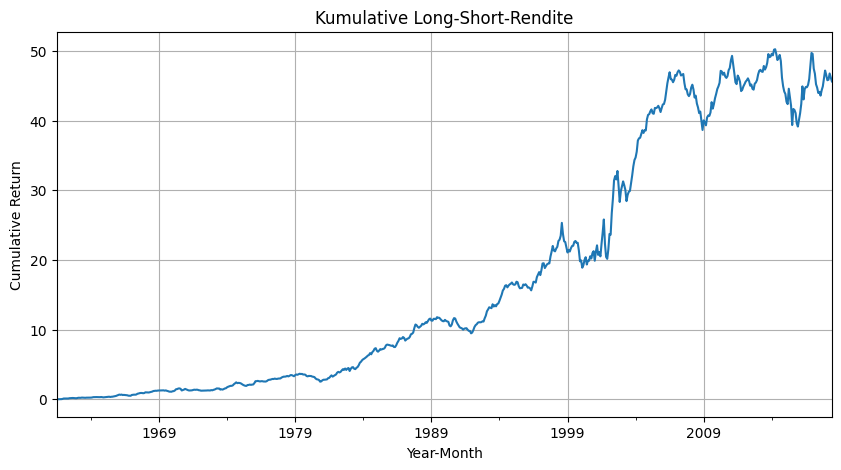

In [15]:
#Value Weighted Portfolio - without financials
long_short_returns = []
bm_dec.index = pd.to_datetime(bm_dec.index, format="%Y-%m")
#returns.index = pd.to_datetime(returns.index)
#returns.index = returns.index.to_period("M")
log_returns = []

price_long_ts = []
dividends_long_ts = []
bookvalue_long_ts = []
price_minus_long_ts = []
bookvalue_minus_long_ts = []
dividends_m_long_ts = []
dividends_m_short_ts = []
long_log_returns = []

price_short_ts = []
dividends_short_ts = []
bookvalue_short_ts = []
price_minus_short_ts = []
bookvalue_minus_short_ts = []
short_log_returns = []

portfolio_value_long = []
portfolio_value_short = []

top_permno_all = []
bottom_permno_all = []

top_permnos = []
bottom_permnos = []

long_ret = []
pb_long = []
pb_short = []
bv_pershare_short = []

ann_ret_long = []
ann_ret_short = []

price_minus_long_monthly = []
price_minus_short_monthly = []

dividends_m_long_monthly = []
dividends_m_short_monthly = []

price_long_monthly = []
price_short_monthly = []

stock_duration_tracker = {}  # Will track how long each stock stays in value/growth
portfolio_compositions = {
    'value': {},  # year: [list of permnos]
    'growth': {}  # year: [list of permnos]
}
duration_results = {
    'value': [],
    'growth': []
}

for year in sorted(set(date.year for date in bm_dec.index)):
    

    bv_long_monthly = []
    bv_short_monthly = []

    div_short_monthly = []
    div_long_monthly = []

    
    date = pd.Timestamp(f"{year}-06")
    date_dec = pd.Timestamp(f"{year-1}-10")
    if date_dec not in bm_dec.index:
        continue

    # Timeframe: July-June
    month_range = pd.date_range(start=date + pd.DateOffset(months=1), periods=12, freq="ME")
    month_range = month_range.to_period('M')

    target_date = f"{year}-06" 
    top_date = pd.to_datetime(target_date)
    df['date'] = pd.to_datetime(df['date'])

    #Since the dataset contains data upto December 2018 and the fiscal year begins in June the loop would try to access data in 2019
    if year == 2018:
        continue 

    """"
        Computation of X_t-: The evaluation of the past portfolio at the day of the rebalancing.

        In means of cleaner code, the positions of the past portfolio will be accessed before the new stocks are being selected.
        Therefore the first year would cause an exception, which will be treated by adding NaN values in the first year.
        

    """

    #Top Permnos
    if len(top_permnos) == 0:
        print("This is year: ", year) #Dummy
        price_minus_long_ts.append({"date" : f"{year}-06", "avg_value" : np.nan})
        bookvalue_minus_long_ts.append({"date" : f"{year}-06", "avg_value" : np.nan})
        dividends_m_long_ts.append({'date': f'{year}-06', 'avg_value': np.nan})
        ann_ret_long.append({'date': f'{year}-06', 'ann_ret_long': np.nan})
    else:
        #Market Capitalization
        shrout_filtered_m_long = df[(df['date'] == top_date) & (df['permno'].isin(top_permnos))]
        shrout_series_m_long = shrout_filtered_m_long.set_index('permno')['adj_shrout']
        top_m_prc = price.loc[(f"{year}-06"), price.columns.intersection(top_permnos)].dropna()
        sharesoutstanding_m_long = shrout_series_m_long.reindex(top_m_prc.index) *1000
        long_m_prc = top_m_prc * sharesoutstanding_m_long
        price_minus_long_ts.append({"date" : top_date, "avg_value" : sum(long_m_prc)})
        
        #Bookvalue
        top_m_bv = bookvalue.loc[(f"{year}-06"), bookvalue.columns.intersection(top_permnos)].dropna()
        bookvalue_minus_long_ts.append({"date" : f"{year}-06", "avg_value" : sum(top_m_bv)})

        #Annual Returns
        ann_top_rets = returns.loc[f'{year}-06', returns.columns.intersection(top_permnos)]
        ann_avg_top_rets = np.nanmean(ann_top_rets)
        ann_ret_long.append({'date': f'{year}-06', 'ann_ret_long': ann_avg_top_rets})

        for m in month_range:
            #Computations for monthly returns
            date = m.to_timestamp()
            shrout_filtered_m_long_monthly = df[(df['date'] == date) & (df['permno'].isin(top_permnos))]
            shrout_series_m_long_monthly = shrout_filtered_m_long_monthly.set_index('permno')['adj_shrout']
            top_m_prc_monthly = price.loc[date, price.columns.intersection(top_permnos)].dropna()
            sharesoutstanding_long_m_prc = shrout_series_m_long_monthly.reindex(top_m_prc_monthly.index) *1000
            long_m_prc_monthly = top_m_prc_monthly * sharesoutstanding_long_m_prc
            price_minus_long_monthly.append({'date': date, 'avg_value': long_m_prc_monthly.sum()})

            #Dividends
            top_m_div = dividends.loc[date, dividends.columns.intersection(top_permnos)].dropna()
            sharesoutstanding_long_m_div = shrout_series_m_long_monthly.reindex(top_m_div.index) *1000
            long_m_div = top_m_div * sharesoutstanding_long_m_div
            dividends_m_long_monthly.append({"date" : date, "avg_value" :long_m_div.sum()})

        #dividends_m_long_ts.extend(dividends_m_long_monthly)


    #Bottom Permnos
    if len(bottom_permnos) == 0:
        print("This is year (bottom): ", year) #Dummy
        price_minus_short_ts.append({"date" : f"{year}-06", "avg_value" : np.nan})
        bookvalue_minus_short_ts.append({"date" : f"{year}-06", "avg_value" : np.nan})
        dividends_m_short_ts.append({'date': f'{year}-06', 'avg_value': np.nan})
        ann_ret_short.append({'date': f'{year}-06', 'ann_ret_short': np.nan})
    else:
        #Market Capitalization
        shrout_filtered_m_short = df[(df['date'] == top_date) & (df['permno'].isin(bottom_permnos))]
        shrout_series_m_short = shrout_filtered_m_short.set_index('permno')['adj_shrout']
        bottom_m_prc = price.loc[(f"{year}-06"), price.columns.intersection(bottom_permnos)].dropna()
        sharesoutstanding_m_short = shrout_series_m_short.reindex(bottom_m_prc.index) * 1000
        short_m_prc = bottom_m_prc * sharesoutstanding_m_short
        price_minus_short_ts.append({"date" : top_date, "avg_value" :sum(short_m_prc)})

        #Bookvalue
        bottom_m_bv = bookvalue.loc[(f"{year}-06"), bookvalue.columns.intersection(bottom_permnos)].dropna()
        bookvalue_minus_short_ts.append({"date" : f"{year}-06", "avg_value" : sum(bottom_m_bv)})

        #Annual Returns
        ann_bottom_rets = returns.loc[f'{year}-06', returns.columns.intersection(bottom_permnos)]
        ann_avg_bottom_rets = np.nanmean(ann_bottom_rets)
        ann_ret_short.append({'date': f'{year}-06', 'ann_ret_short': ann_avg_bottom_rets})

        for m in month_range:
            #Computations for monthly returns
            date = m.to_timestamp()
            shrout_filtered_m_short_monthly = df[(df['date'] == date) & (df['permno'].isin(bottom_permnos))]
            shrout_series_m_short_monthly = shrout_filtered_m_short_monthly.set_index('permno')['adj_shrout']
            bottom_m_prc_monthly = price.loc[date, price.columns.intersection(bottom_permnos)].dropna()
            sharesoutstanding_short_m_prc_monthly = shrout_series_m_short_monthly.reindex(bottom_m_prc_monthly.index) *1000
            short_m_prc_monthly = bottom_m_prc_monthly * sharesoutstanding_short_m_prc_monthly
            price_minus_short_monthly.append({'date': date, 'avg_value': short_m_prc_monthly.sum()})

            #Dividends
            bottom_m_div = dividends.loc[date, dividends.columns.intersection(bottom_permnos)].dropna()
            sharesoutstanding_short_m_div = shrout_series_m_short_monthly.reindex(bottom_m_div.index) *1000
            short_m_div = bottom_m_div * sharesoutstanding_short_m_div
            dividends_m_short_monthly.append({"date" : date, "avg_value" :short_m_div.sum()})
        
        #dividends_m_short_ts.extend(dividends_m_short_monthly)

    
    
    
    

    """"
        Stock Selection:

        All Stocks in the available Dataset are being sorted in a descending order by Book-to-market ratio.

        "Clean Row" accesses the DataFrame bm_dec, which contains the book-to-market ratios in wide-format. 
        Therefore the length of a row is equal to the number of available stocks. Since the only condition for a stock
        to be picked is that it is listed at the day of the portfolio selection, there is no look-ahead bias.

        The top 30% of stocks are being selected for the long-positions, the bottom 30% for the short-positions, respectively.


    """
    #Only stocks which contain values for June of a year get selected. Later months are not considered -> no look-ahead bias

    financial_sics = range(6000, 6700)  # Standard SIC codes for financials, insurance, real estate

    # Get the hsiccd for the current date (adjust based on your data structure)
    current_hsiccd = hsiccd_data.loc[date_dec]  # or however you access hsiccd data

    # Filter out financial firms before sorting
    clean_row = bm_dec.loc[date_dec].dropna()
    non_financial_mask = ~current_hsiccd[clean_row.index].isin(financial_sics)
    clean_row = clean_row[non_financial_mask].sort_values(ascending=False)
 
    n = len(clean_row)
    if n == 0:
        continue

    k = int(n * 0.3)
    top_permnos = clean_row.iloc[:k].index.tolist()
    bottom_permnos = clean_row.iloc[-k:].index.tolist() 

    top_permno_year = pd.DataFrame({"date": date, "permno": top_permnos}) 
    top_permno_all.append(top_permno_year)

    bottom_permno_year = pd.DataFrame({"date": date, "permno": bottom_permnos})
    bottom_permno_all.append(bottom_permno_year)

    """
        Track Stocks in Value/Growth Portfolio
    """

    # Store portfolio compositions for duration analysis
    portfolio_compositions['value'][year] = top_permnos.copy()
    portfolio_compositions['growth'][year] = bottom_permnos.copy()

    # Track duration for each stock
    for permno in top_permnos:
        if permno not in stock_duration_tracker:
            stock_duration_tracker[permno] = {'type': 'value', 'start_year': year, 'consecutive_years': 1}
        else:
            if stock_duration_tracker[permno]['type'] == 'value':
                # Stock continues in value portfolio
                stock_duration_tracker[permno]['consecutive_years'] += 1
            else:
                # Stock switched from growth to value - record previous duration and restart
                prev_duration = stock_duration_tracker[permno]['consecutive_years']
                duration_results[stock_duration_tracker[permno]['type']].append({
                    'permno': permno,
                    'duration': prev_duration,
                    'end_year': year - 1,
                    'start_year': stock_duration_tracker[permno]['start_year']
                })
                stock_duration_tracker[permno] = {'type': 'value', 'start_year': year, 'consecutive_years': 1}

    for permno in bottom_permnos:
        if permno not in stock_duration_tracker:
            stock_duration_tracker[permno] = {'type': 'growth', 'start_year': year, 'consecutive_years': 1}
        else:
            if stock_duration_tracker[permno]['type'] == 'growth':
                # Stock continues in growth portfolio
                stock_duration_tracker[permno]['consecutive_years'] += 1
            else:
                # Stock switched from value to growth - record previous duration and restart
                prev_duration = stock_duration_tracker[permno]['consecutive_years']
                duration_results[stock_duration_tracker[permno]['type']].append({
                    'permno': permno,
                    'duration': prev_duration,
                    'end_year': year - 1,
                    'start_year': stock_duration_tracker[permno]['start_year']
                })
                stock_duration_tracker[permno] = {'type': 'growth', 'start_year': year, 'consecutive_years': 1}


    """

            Computation of current values:

            After the new stocks have been selected the values of P_t+, B_t+ and D_t+ will
            be computed. 

            Change on June 25th: Loop over the months will only be used for dividends, since only the 
            values at the target date will be used for later calculations.


    """

    #Portfolio weighted market capitalization      Long 
    shrout_filtered_long = df[(df['date'] == f'{year}-06') & (df['permno'].isin(top_permnos))]
    shrout_series_long = shrout_filtered_long.set_index('permno')['adj_shrout']

    top_prc = price.loc[f'{year}-06', price.columns.intersection(top_permnos)].dropna()
    sharesoutstanding_long = shrout_series_long.reindex(top_prc.index) *1000
    long_prc = top_prc * sharesoutstanding_long
    price_long_ts.append({'date': f'{year}-06', 'avg_value': long_prc.sum()})  

    #Portfolio weighted market capitalization      Short
    shrout_filtered_short = df[(df['date'] == f'{year}-06') & (df['permno'].isin(bottom_permnos))]
    shrout_series_short = shrout_filtered_short.set_index('permno')['adj_shrout']

    bottom_prc = price.loc[f'{year}-06', price.columns.intersection(bottom_permnos)].dropna()
    sharesoutstanding_short = shrout_series_short.reindex(bottom_prc.index) *1000
    short_prc = bottom_prc * sharesoutstanding_short
    price_short_ts.append({'date': f'{year}-06', 'avg_value': short_prc.sum()})

    #Bookvalue
    top_bv = bookvalue.loc[f'{year}-06', bookvalue.columns.intersection(top_permnos)].dropna()
    bookvalue_long_ts.append({'date': f'{year}-06', 'avg_value' : top_bv.sum()}) 

    bottom_bv = bookvalue.loc[f'{year}-06', bookvalue.columns.intersection(bottom_permnos)].dropna()
    bookvalue_short_ts.append({'date': f'{year}-06', 'avg_value' : bottom_bv.sum()})
    

    pb_long.append({'date': f'{year}-06', 'pb_long' : long_prc.sum()/bottom_bv.sum()})
    pb_short.append({'date': f'{year}-06', 'pb_short': short_prc.sum()/top_bv.sum()})

    

    for m in month_range:
        if m not in returns.index:
            print("m not in returns.index")
            continue
        

        #Computations for monthly returns
        date = m.to_timestamp()
        #Short-Positions
        shrout_filtered_short_monthly = df[(df['date'] == date) & (df['permno'].isin(bottom_permnos))]
        shrout_series_short_monthly = shrout_filtered_short_monthly.set_index('permno')['adj_shrout']
        bottom_prc_monthly = price.loc[date, price.columns.intersection(bottom_permnos)].dropna()
        sharesoutstanding_short_prc_monthly = shrout_series_short_monthly.reindex(bottom_prc_monthly.index) *1000
        short_prc_monthly = bottom_prc_monthly * sharesoutstanding_short_prc_monthly
        if short_prc_monthly.notna().any():
            price_short_monthly.append({'date': date, 'avg_value': short_prc_monthly.sum()})
        else:
            print(f"No valid prices for {date} — skipping.")
        
        #Long-Positions
        shrout_filtered_long_monthly = df[(df['date'] == date) & (df['permno'].isin(top_permnos))]
        shrout_series_long_monthly = shrout_filtered_long_monthly.set_index('permno')['adj_shrout']
        top_prc_monthly = price.loc[date, price.columns.intersection(top_permnos)].dropna()
        sharesoutstanding_long_prc_monthly = shrout_series_long_monthly.reindex(top_prc_monthly.index) *1000
        long_prc_monthly = top_prc_monthly * sharesoutstanding_long_prc_monthly
        if long_prc_monthly.notna().any():
            price_long_monthly.append({'date': date, 'avg_value': long_prc_monthly.sum()})
        else:
            print(f"No valid prices for {date} — skipping.")

        top_rets = returns.loc[m, returns.columns.intersection(top_permnos)]
        bottom_rets = returns.loc[m, returns.columns.intersection(bottom_permnos)]

        #Dividends
        top_div = dividends.loc[m, dividends.columns.intersection(top_permnos)].dropna()
        sharesoutstanding_long_div = shrout_series_long_monthly.reindex(top_div.index) *1000
        long_div = top_div * sharesoutstanding_long_div
        div_long_monthly.append({'date': date, 'avg_value' : long_div.sum()})

        bottom_div = dividends.loc[m, dividends.columns.intersection(bottom_permnos)].dropna()
        sharesoutstanding_short_div = shrout_series_short_monthly.reindex(bottom_div.index) *1000
        short_div = bottom_div * sharesoutstanding_short_div
        div_short_monthly.append({'date': date, 'avg_value' : short_div.sum()})

        if top_rets.empty or bottom_rets.empty:
            continue

        avg_top = np.nanmean(top_rets)
        avg_bottom = np.nanmean(bottom_rets)
        spread = avg_top - avg_bottom

        long_short_returns.append((m, spread))
        long_ret.append({"date": date, "return": (top_prc/top_prc.shift(1))})

    dividends_long_ts.extend(div_long_monthly)
    dividends_short_ts.extend(div_short_monthly)   
    
# Convert to DataFrame and set index
df_ls_nonfin = pd.DataFrame(long_short_returns, columns=["date", "long_short_ret"])
#df_ls['date'] = pd.to_datetime(df_ls["date"])      
df_ls_nonfin.set_index("date", inplace=True)            
#df_ls.index = df_ls.index.to_period('M')              

# Calculate cumulative return
df_ls_nonfin['cumret'] = (1 + df_ls_nonfin['long_short_ret']).cumprod() - 1
df_ls_nonfin['cumret'] = pd.to_numeric(df_ls_nonfin['cumret'], errors='coerce')

# Plot
df_ls_nonfin['cumret'].plot(title="Kumulative Long-Short-Rendite", figsize=(10, 5))
plt.ylabel("Cumulative Return")
plt.xlabel("Year-Month")
plt.grid(True)
plt.show()


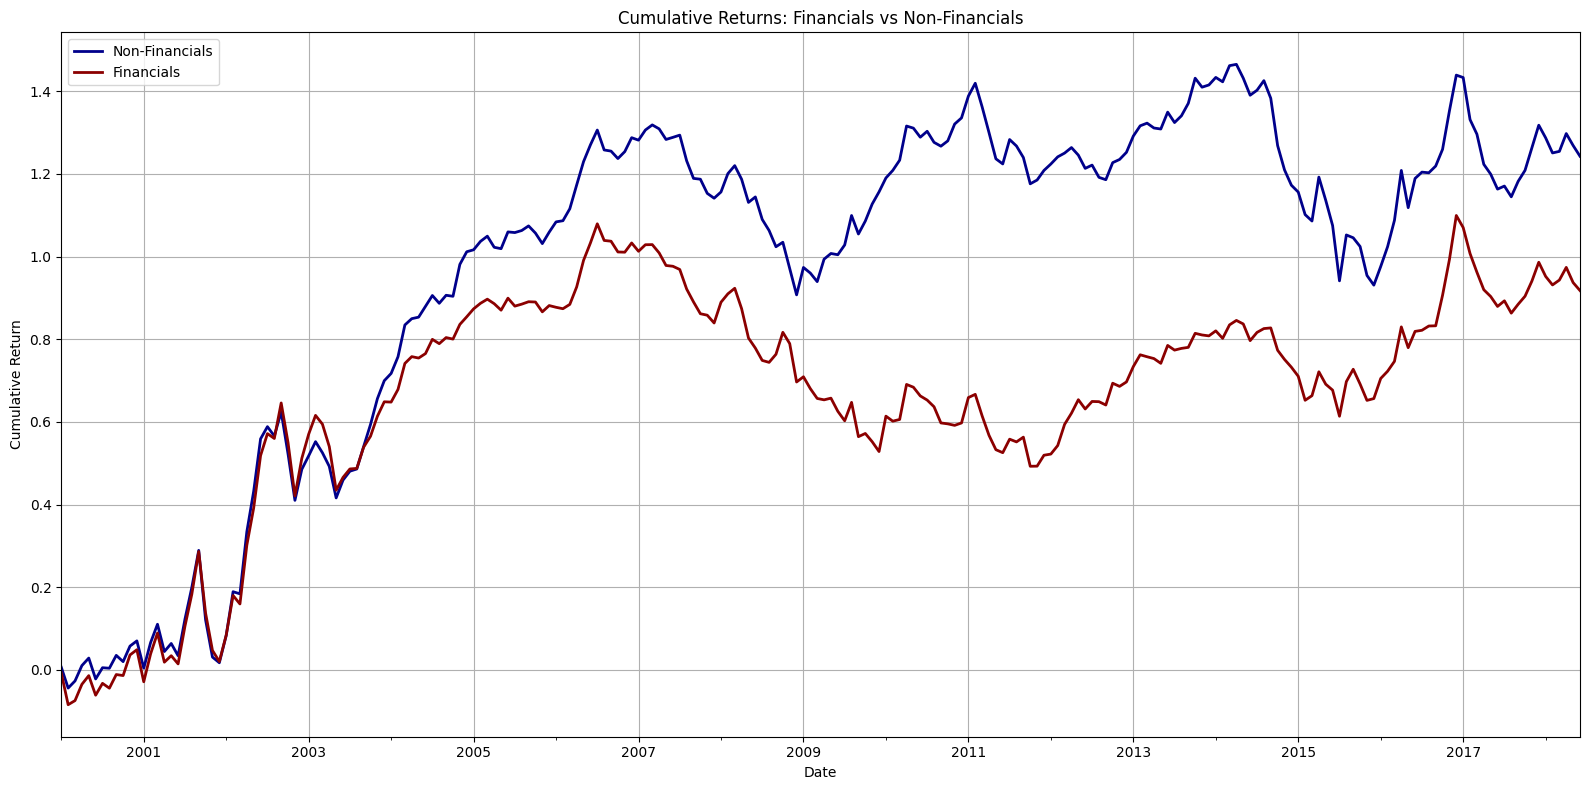

In [38]:
#Cumulative Return Comparison (with financials vs. without financials) post 2000

df_ls_nonfin.rename(columns={'long_short_ret': 'lsret-nonfin'}, inplace=True)
comparison_df = pd.concat([df_ls['long_short_ret'], df_ls_nonfin['lsret-nonfin']], axis=1, join='inner')
comparison_df = comparison_df[comparison_df.index.year >= 2000]
comparison_df['cumret'] = (1+comparison_df['long_short_ret']).cumprod() -1
comparison_df['cumret-nonfin'] = (1+comparison_df['lsret-nonfin']).cumprod()-1

#Create figure and axis
plt.figure(figsize=(16, 8))

# Plot both time series
comparison_df['cumret-nonfin'].plot(linewidth=2, color="darkblue", label='Non-Financials')
comparison_df['cumret'].plot(linewidth=2, color="darkred", label='Financials')

# Add legend, labels, and grid
plt.title("Cumulative Returns: Financials vs Non-Financials")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

=== PORTFOLIO DURATION ANALYSIS ===

Value Portfolio Average Durations:
Overall: 4.89 years
Pre-Crisis (before 2008): 3.59 years
Post-Crisis (2010+): 2.49 years

Growth Portfolio Average Durations:
Overall: 3.92 years
Pre-Crisis (before 2008): 3.10 years
Post-Crisis (2010+): 2.17 years

Value Portfolio Duration Statistics:
Median duration: 3.00 years
Standard deviation: 5.20 years
Max duration: 49 years
% of stocks lasting only 1 year: 28.0%

Growth Portfolio Duration Statistics:
Median duration: 2.00 years
Standard deviation: 4.60 years
Max duration: 56 years
% of stocks lasting only 1 year: 33.7%


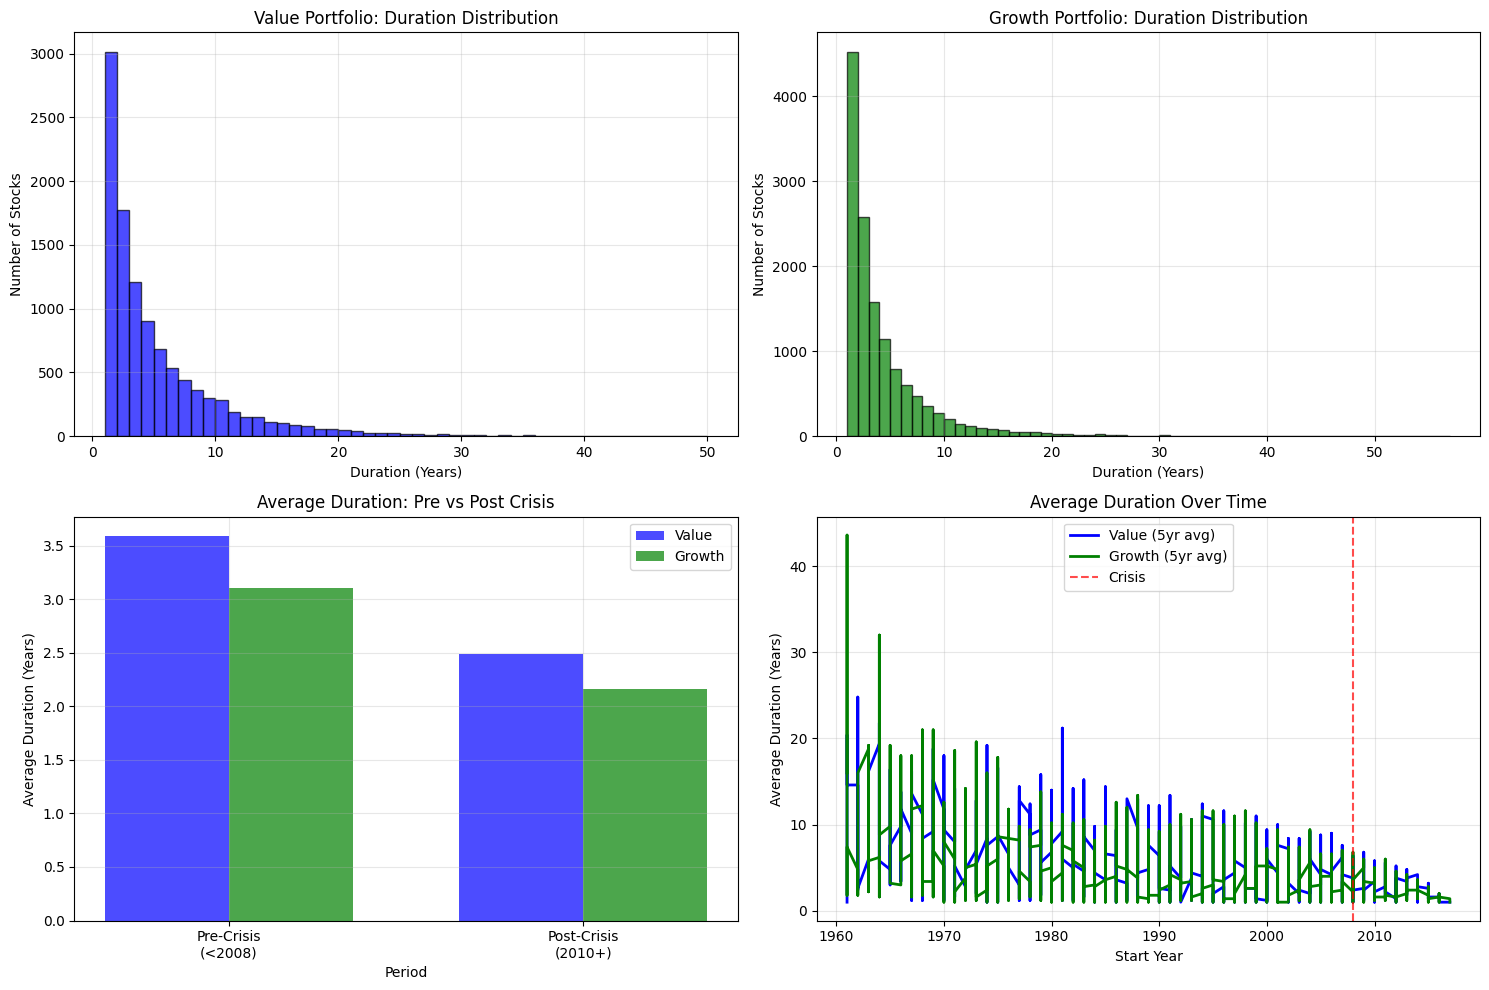


Results exported to 'value_portfolio_durations.csv' and 'growth_portfolio_durations.csv'


In [39]:
#Permno Tracking
# Finalize remaining durations (for stocks that never switched)
for permno, info in stock_duration_tracker.items():
    duration_results[info['type']].append({
        'permno': permno,
        'duration': info['consecutive_years'],
        'end_year': max(sorted(set(date.year for date in bm_dec.index))),  # Last year in data
        'start_year': info['start_year']
    })

# Convert to DataFrames for analysis
value_durations_df = pd.DataFrame(duration_results['value'])
growth_durations_df = pd.DataFrame(duration_results['growth'])

# Define crisis periods
pre_crisis = (value_durations_df['start_year'] < 2008) & (value_durations_df['end_year'] < 2008)
post_crisis = value_durations_df['start_year'] >= 2010

pre_crisis_growth = (growth_durations_df['start_year'] < 2008) & (growth_durations_df['end_year'] < 2008)
post_crisis_growth = growth_durations_df['start_year'] >= 2010

# Calculate average durations
print("=== PORTFOLIO DURATION ANALYSIS ===")
print(f"\nValue Portfolio Average Durations:")
print(f"Overall: {value_durations_df['duration'].mean():.2f} years")
print(f"Pre-Crisis (before 2008): {value_durations_df[pre_crisis]['duration'].mean():.2f} years")
print(f"Post-Crisis (2010+): {value_durations_df[post_crisis]['duration'].mean():.2f} years")

print(f"\nGrowth Portfolio Average Durations:")
print(f"Overall: {growth_durations_df['duration'].mean():.2f} years")
print(f"Pre-Crisis (before 2008): {growth_durations_df[pre_crisis_growth]['duration'].mean():.2f} years")
print(f"Post-Crisis (2010+): {growth_durations_df[post_crisis_growth]['duration'].mean():.2f} years")

# Additional statistics
print(f"\nValue Portfolio Duration Statistics:")
print(f"Median duration: {value_durations_df['duration'].median():.2f} years")
print(f"Standard deviation: {value_durations_df['duration'].std():.2f} years")
print(f"Max duration: {value_durations_df['duration'].max()} years")
print(f"% of stocks lasting only 1 year: {(value_durations_df['duration'] == 1).mean()*100:.1f}%")

print(f"\nGrowth Portfolio Duration Statistics:")
print(f"Median duration: {growth_durations_df['duration'].median():.2f} years")
print(f"Standard deviation: {growth_durations_df['duration'].std():.2f} years")
print(f"Max duration: {growth_durations_df['duration'].max()} years")
print(f"% of stocks lasting only 1 year: {(growth_durations_df['duration'] == 1).mean()*100:.1f}%")

# Create visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Duration distributions
ax1.hist(value_durations_df['duration'], bins=range(1, value_durations_df['duration'].max()+2), 
         alpha=0.7, label='Value', color='blue', edgecolor='black')
ax1.set_title('Value Portfolio: Duration Distribution')
ax1.set_xlabel('Duration (Years)')
ax1.set_ylabel('Number of Stocks')
ax1.grid(True, alpha=0.3)

ax2.hist(growth_durations_df['duration'], bins=range(1, growth_durations_df['duration'].max()+2), 
         alpha=0.7, label='Growth', color='green', edgecolor='black')
ax2.set_title('Growth Portfolio: Duration Distribution')
ax2.set_xlabel('Duration (Years)')
ax2.set_ylabel('Number of Stocks')
ax2.grid(True, alpha=0.3)

# Pre vs Post Crisis comparison
periods = ['Pre-Crisis\n(<2008)', 'Post-Crisis\n(2010+)']
value_means = [value_durations_df[pre_crisis]['duration'].mean(), 
               value_durations_df[post_crisis]['duration'].mean()]
growth_means = [growth_durations_df[pre_crisis_growth]['duration'].mean(), 
                growth_durations_df[post_crisis_growth]['duration'].mean()]

x = range(len(periods))
width = 0.35

ax3.bar([i - width/2 for i in x], value_means, width, label='Value', color='blue', alpha=0.7)
ax3.bar([i + width/2 for i in x], growth_means, width, label='Growth', color='green', alpha=0.7)
ax3.set_title('Average Duration: Pre vs Post Crisis')
ax3.set_xlabel('Period')
ax3.set_ylabel('Average Duration (Years)')
ax3.set_xticks(x)
ax3.set_xticklabels(periods)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Duration over time (rolling average)
value_durations_df_sorted = value_durations_df.sort_values('start_year')
growth_durations_df_sorted = growth_durations_df.sort_values('start_year')

# Calculate 5-year rolling averages
window = 5
if len(value_durations_df_sorted) >= window:
    value_rolling = value_durations_df_sorted.set_index('start_year')['duration'].rolling(window=window, min_periods=1).mean()
    growth_rolling = growth_durations_df_sorted.set_index('start_year')['duration'].rolling(window=window, min_periods=1).mean()
    
    ax4.plot(value_rolling.index, value_rolling.values, label='Value (5yr avg)', color='blue', linewidth=2)
    ax4.plot(growth_rolling.index, growth_rolling.values, label='Growth (5yr avg)', color='green', linewidth=2)
    ax4.axvline(x=2008, color='red', linestyle='--', alpha=0.7, label='Crisis')
    ax4.set_title('Average Duration Over Time')
    ax4.set_xlabel('Start Year')
    ax4.set_ylabel('Average Duration (Years)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Export results for further analysis
value_durations_df.to_csv('value_portfolio_durations.csv', index=False)
growth_durations_df.to_csv('growth_portfolio_durations.csv', index=False)
print(f"\nResults exported to 'value_portfolio_durations.csv' and 'growth_portfolio_durations.csv'")

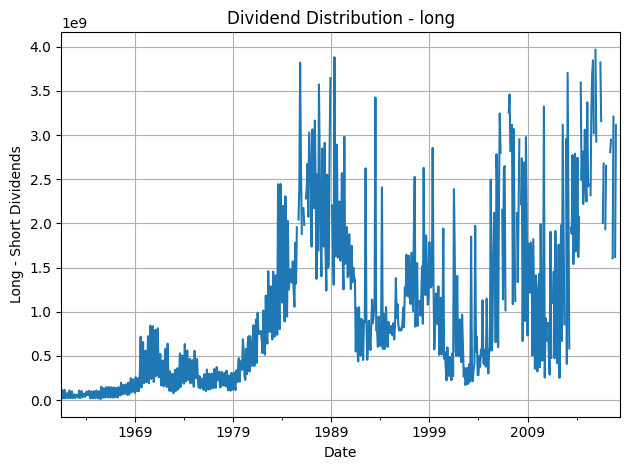

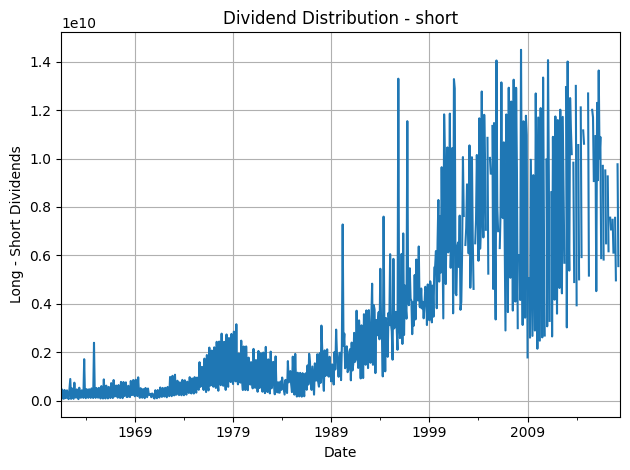

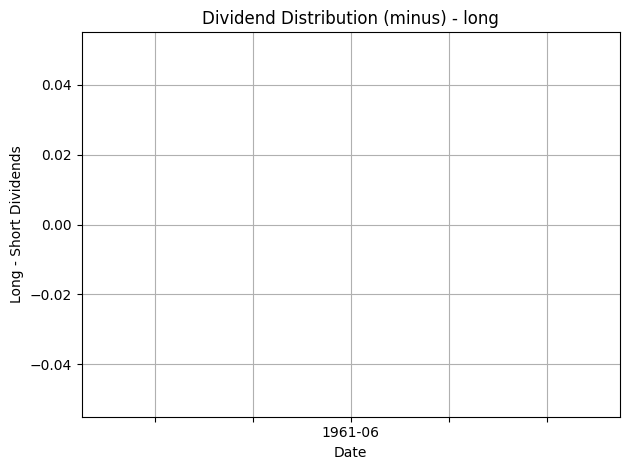

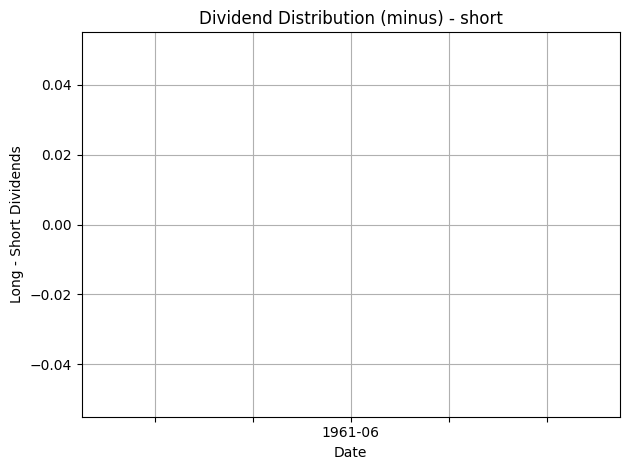

In [53]:
#Dividends - long
df_dividends_long_ts = pd.DataFrame(dividends_long_ts)
df_dividends_long_ts.set_index("date", inplace=True)
#df_dividends_long_ts.index = df_dividends_long_ts.index.to_timestamp()


# 1. IQR-Methode
Q1 = df_dividends_long_ts.quantile(0.25)
Q3 = df_dividends_long_ts.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtere nur Werte innerhalb des Bereichs
df_dividends_long_adj= df_dividends_long_ts[(df_dividends_long_ts >= lower_bound) & (df_dividends_long_ts <= upper_bound)]


#Dividends - short
df_dividends_short_ts = pd.DataFrame(dividends_short_ts)
df_dividends_short_ts.set_index("date", inplace=True)
#df_dividends_short_ts.index = df_dividends_short_ts.index.to_timestamp()

# 1. IQR-Methode (s for short)
Q1s = df_dividends_short_ts.quantile(0.25)
Q3s = df_dividends_short_ts.quantile(0.75)
IQRs = Q3s - Q1s

lower_boundS = Q1s - 1.5 * IQRs
upper_boundS = Q3s + 1.5 * IQRs

# Filtere nur Werte innerhalb des Bereichs
df_dividends_short_adj= df_dividends_short_ts[(df_dividends_short_ts >= lower_boundS) & (df_dividends_short_ts <= upper_boundS)]


df_dividends_long_adj.plot(title="Dividend Distribution - long", legend=False)
plt.ylabel("Long - Short Dividends")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()

df_dividends_short_adj.plot(title="Dividend Distribution - short", legend=False)
plt.ylabel("Long - Short Dividends")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()

df_div_m_long_ts = pd.DataFrame(dividends_m_long_ts)
df_div_m_long_ts.set_index("date", inplace=True)
#df_div_m_long_ts.index = pd.to_datetime(df_div_m_long_ts.index)

# 1. IQR-Methode (ml for minus long)
Q1ml = df_div_m_long_ts.quantile(0.25)
Q3ml = df_div_m_long_ts.quantile(0.75)
IQRml = Q3ml - Q1ml

lower_boundml = Q1ml - 1.5 * IQRml
upper_boundml = Q3ml + 1.5 * IQRml

# Filtere nur Werte innerhalb des Bereichs
df_div_m_long_adj= df_div_m_long_ts[(df_div_m_long_ts >= lower_boundml) & (df_div_m_long_ts <= upper_boundml)]

df_div_m_short_ts = pd.DataFrame(dividends_m_short_ts)
df_div_m_short_ts.set_index("date", inplace=True)
#df_div_m_short_ts.index = pd.to_datetime(df_div_m_short_ts.index)

# 1. IQR-Methode
Q1ms = df_dividends_short_ts.quantile(0.25)
Q3ms = df_dividends_short_ts.quantile(0.75)
IQRms = Q3ms - Q1ms

lower_boundms = Q1ms - 1.5 * IQRms
upper_boundms = Q3ms + 1.5 * IQRms

# Filtere nur Werte innerhalb des Bereichs
df_div_m_short_adj= df_div_m_short_ts[(df_div_m_short_ts >= lower_boundms) & (df_div_m_short_ts <= upper_boundms)]



df_dividends_minus_long_monthly = pd.DataFrame(dividends_m_long_monthly)
df_dividends_minus_long_monthly.set_index('date', inplace=True)

df_dividends_minus_short_monthly = pd.DataFrame(dividends_m_short_monthly)
df_dividends_minus_short_monthly.set_index('date', inplace=True)


# 1. IQR-Methode (ml for minus long)
q1l = df_dividends_minus_long_monthly.quantile(0.25)
q3l = df_dividends_minus_long_monthly.quantile(0.75)
iqrl = q3l - q1l

lbl = q1l - 1.5 * iqrl
ubl = q3l + 1.5 * iqrl

# Filtere nur Werte innerhalb des Bereichs
df_dividends_minus_long_monthly_adj = df_dividends_minus_long_monthly[(df_dividends_minus_long_monthly >= lbl) & (df_dividends_minus_long_monthly <= ubl)]

# 1. IQR-Methode (ml for minus long)
q1s = df_dividends_minus_short_monthly.quantile(0.25)
q3s = df_dividends_minus_short_monthly.quantile(0.75)
iqrs = q3s - q1s

lbs = q1s - 1.5 * iqrs
ubs = q3s + 1.5 * iqrs

# Filtere nur Werte innerhalb des Bereichs
df_dividends_minus_short_monthly_adj = df_dividends_minus_short_monthly[(df_dividends_minus_short_monthly >= lbs) & (df_dividends_minus_short_monthly <= ubs)]

df_div_m_long_adj.plot(title="Dividend Distribution (minus) - long", legend=False)
plt.ylabel("Long - Short Dividends")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()

df_div_m_short_adj.plot(title="Dividend Distribution (minus) - short", legend=False)
plt.ylabel("Long - Short Dividends")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()

In [65]:
#Data Frame with annual returns
df_ann_ret_long = pd.DataFrame(ann_ret_long)
df_ann_ret_long.set_index('date', inplace=True)
df_ann_ret_long.index = pd.to_datetime(df_ann_ret_long.index)

df_ann_ret_short = pd.DataFrame(ann_ret_short)
df_ann_ret_short.set_index('date', inplace=True)
df_ann_ret_short.index = pd.to_datetime(df_ann_ret_short.index)

#Data for monthly returns
df_price_long_monthly = pd.DataFrame(price_long_monthly)
df_price_long_monthly.set_index('date', inplace=True)

df_price_short_monthly = pd.DataFrame(price_short_monthly)
df_price_short_monthly.set_index('date', inplace=True)

df_price_minus_long_monthly = pd.DataFrame(price_minus_long_monthly)
df_price_minus_long_monthly.set_index('date', inplace=True)

df_price_minus_short_monthly = pd.DataFrame(price_minus_short_monthly)
df_price_minus_short_monthly.set_index('date', inplace=True)

df_bookvalue_minus_long_monthly = pd.DataFrame(bookvalue_minus_long_monthly)
df_bookvalue_minus_long_monthly.set_index('date', inplace=True)

df_bookvalue_minus_short_monthly = pd.DataFrame(bookvalue_minus_short_monthly)
df_bookvalue_minus_short_monthly.set_index('date', inplace=True)

df_bookvalue_long_monthly = pd.DataFrame(bookvalue_long_monthly)
df_bookvalue_long_monthly.set_index('date', inplace=True)

df_bookvalue_short_monthly = pd.DataFrame(bookvalue_short_monthly)
df_bookvalue_short_monthly.set_index('date', inplace=True)


#DataFrame with all permnos over the years
df_top_permno_all = pd.concat(top_permno_all, ignore_index=True)
df_top_permno_all = df_top_permno_all.rename(columns={"year" : "date"})
#df_top_permno_all = df_top_permno_all.set_index("year", drop=True)

df_bottom_permno_all = pd.concat(bottom_permno_all, ignore_index=True)
df_bottom_permno_all = df_bottom_permno_all.rename(columns={"year" : "date"})
#df_bottom_permno_all = df_bottom_permno_all.set_index("year", drop=True)

#Portfolio Weighted Market Cap Tilt at time t for portfolios built at t-1 - long
df_price_minus_long_ts = pd.DataFrame(price_minus_long_ts)
df_price_minus_long_ts.set_index("date", inplace=True)
df_price_minus_long_ts.index = pd.to_datetime(df_price_minus_long_ts.index)

#Portfolio Weighted Market Cap Tilt at time t for portfolios built at t-1 - short
df_price_minus_short_ts = pd.DataFrame(price_minus_short_ts)
df_price_minus_short_ts.set_index("date", inplace=True)
df_price_minus_short_ts.index = pd.to_datetime(df_price_minus_short_ts.index)
#df_price_minus_ts.index = df_price_minus_ts.index.to_timestamp()
"""df_price_minus_long_ts.plot(title="Portfolio Weighted Market Cap Tilt (P-)", legend=False)
#df_price_minus_short_ts.plot()
plt.ylabel("Long Market Cap")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
#plt.show()"""


#Portfolio Weighted Bookvalue at time t for portfolios built at t-1 - long
df_bookvalue_minus_long_ts = pd.DataFrame(bookvalue_minus_long_ts)
df_bookvalue_minus_long_ts.set_index("date", inplace=True)
df_bookvalue_minus_long_ts.index = pd.to_datetime(df_bookvalue_minus_long_ts.index)

#Portfolio Weighted Bookvalue at time t for portfolios built at t-1 - short
df_bookvalue_minus_short_ts = pd.DataFrame(bookvalue_minus_short_ts)
df_bookvalue_minus_short_ts.set_index("date", inplace=True)
df_bookvalue_minus_short_ts.index = pd.to_datetime(df_bookvalue_minus_short_ts.index)

"""#df_bookvalue_minus_ts.index = df_bookvalue_minus_ts.index.to_timestamp()
df_bookvalue_minus_long_ts.plot(title="Portfolio Weighted Bookvalue Tilt (B-)", legend=False)
plt.ylabel("Long - Short Bookvalue")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
#plt.show()"""

#Portfolio Weighted Market Cap Tilt (P) - long
df_price_long_ts = pd.DataFrame(price_long_ts)
df_price_long_ts.set_index("date", inplace=True)
df_price_long_ts.index = pd.to_datetime(df_price_long_ts.index)

#Portfolio Weighted Market Cap Tilt (P) - short
df_price_short_ts = pd.DataFrame(price_short_ts)
df_price_short_ts.set_index("date", inplace=True)
df_price_short_ts.index = pd.to_datetime(df_price_short_ts.index)

"""#df_price_minus_ts.index = df_price_minus_ts.index.to_timestamp()
df_price_long_ts.plot(title="Portfolio Weighted Market Cap Tilt (P) - long", legend=False)
plt.ylabel("Long - Short Market Cap")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
#plt.show()

df_price_short_ts.plot(title="Portfolio Weighted Market Cap Tilt (P) - short", legend=False)
plt.ylabel("Long - Short Market Cap")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
#plt.show()"""

#Portfolio Weighted Bookvalue - long
df_bookvalue_long_ts = pd.DataFrame(bookvalue_long_ts)
df_bookvalue_long_ts.set_index("date", inplace=True)
df_bookvalue_long_ts.index = pd.to_datetime(df_bookvalue_long_ts.index)

#Portfolio Weighted Bookvalue - short
df_bookvalue_short_ts = pd.DataFrame(bookvalue_short_ts)
df_bookvalue_short_ts.set_index("date", inplace=True)
df_bookvalue_short_ts.index = pd.to_datetime(df_bookvalue_short_ts.index)

"""#df_price_minus_ts.index = df_price_minus_ts.index.to_timestamp()
df_bookvalue_long_ts.plot(title="Portfolio Weighted Bookvalue Tilt (B) - long", legend=False)
plt.ylabel("Long - Short Bookvalue")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
#plt.show()

df_bookvalue_short_ts.plot(title="Portfolio Weighted Bookvalue Tilt (B) - short", legend=False)
plt.ylabel("Long - Short Bookvalue")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
#plt.show()
"""




"""df_portfolio_value_long = pd.DataFrame(portfolio_value_long)
df_portfolio_value_long.set_index("date", inplace=True)
df_portfolio_value_long.index = df_portfolio_value_long.index.to_timestamp()
df_portfolio_value_short = pd.DataFrame(portfolio_value_short)
df_portfolio_value_short.set_index("date", inplace=True)
df_portfolio_value_short.index = df_portfolio_value_short.index.to_timestamp()
# Ensure both are pandas Series and sorted
df_portfolio_value_long = df_portfolio_value_long.sort_index()
df_portfolio_value_short = df_portfolio_value_short.sort_index()"""
"""
# Sicherstellen, dass alle Inputs Series mit korrektem Index sind
long_val = df_price_long_ts.squeeze()
long_div = df_dividends_long_ts.squeeze()
short_val = df_price_short_ts.squeeze()
short_div = df_dividends_short_ts.squeeze()

# Index angleichen (falls nötig)
long_div = long_div.reindex_like(long_val).fillna(0)
short_div = short_div.reindex_like(short_val).fillna(0)

# Log-Returns berechnen
log_ret_long = np.log(long_val + long_div) - np.log((long_val).shift(1))
log_ret_short = np.log(short_val + short_div) - np.log((short_val).shift(1))

# Portfolio-Log-Return: Long - Short
portfolio_log_returns = log_ret_long - log_ret_short
df_portfolio_log_returns = pd.DataFrame(portfolio_log_returns)
portfolio_log_returns_ann = df_portfolio_log_returns.resample('Y').sum()"""
 #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# Make sure all relevant columns are numeric
df_bookvalue_long_ts = df_bookvalue_long_ts.apply(pd.to_numeric, errors='coerce')
df_bookvalue_minus_long_ts = df_bookvalue_minus_long_ts.apply(pd.to_numeric, errors='coerce')
df_price_long_ts = df_price_long_ts.apply(pd.to_numeric, errors='coerce')
df_price_minus_long_ts = df_price_minus_long_ts.apply(pd.to_numeric, errors='coerce')
df_dividends_long_ts = df_dividends_long_ts.apply(pd.to_numeric, errors='coerce')
df_bookvalue_short_ts = df_bookvalue_short_ts.apply(pd.to_numeric, errors='coerce')
df_bookvalue_minus_short_ts = df_bookvalue_minus_short_ts.apply(pd.to_numeric, errors='coerce')
df_price_short_ts = df_price_short_ts.apply(pd.to_numeric, errors='coerce')
df_price_minus_short_ts = df_price_minus_short_ts.apply(pd.to_numeric, errors='coerce')
df_dividends_short_ts = df_dividends_short_ts.apply(pd.to_numeric, errors='coerce')

"""# Align indexes if needed
common_index = df_bookvalue_long_ts.index.intersection(df_price_long_ts.index)
df_bookvalue_long_ts = df_bookvalue_long_ts.loc[common_index]
df_bookvalue_minus_long_ts = df_bookvalue_minus_long_ts.loc[common_index]
df_price_long_ts = df_price_long_ts.loc[common_index]
df_price_minus_long_ts = df_price_minus_long_ts.loc[common_index]
df_dividends_long_ts = df_dividends_long_ts.loc[common_index]
common_index = df_bookvalue_short_ts.index.intersection(df_price_short_ts.index)
df_bookvalue_short_ts = df_bookvalue_short_ts.loc[common_index]
df_bookvalue_minus_short_ts = df_bookvalue_minus_short_ts.loc[common_index]
df_price_short_ts = df_price_short_ts.loc[common_index]
df_price_minus_short_ts = df_price_minus_short_ts.loc[common_index]
df_dividends_short_ts = df_dividends_short_ts.loc[common_index]"""

# Filter zero or negative values to avoid log issues
valid = (df_bookvalue_long_ts.shift(1) > 0) & (df_price_minus_long_ts > 0)
valid &= df_bookvalue_minus_long_ts > 0
valid &= df_price_long_ts > 0
valid &= df_bookvalue_long_ts > 0

valid = (df_bookvalue_short_ts.shift(1) > 0) & (df_price_minus_short_ts > 0)
valid &= df_bookvalue_minus_short_ts > 0
valid &= df_price_short_ts > 0
valid &= df_bookvalue_short_ts > 0

#Return to Value
#annual_log_return =df_annual_log_returns_long_ts - df_annual_log_returns_short_ts

#Return to Value in three components
#change_in_aggregate_valuation_long = np.log(df_price_long_ts/df_bookvalue_long_ts)-np.log(df_price_long_ts.shift(1)/df_bookvalue_long_ts.shift(1))
#change_in_aggregate_valuation_short = np.log(df_price_short_ts/df_bookvalue_short_ts)-np.log(df_price_short_ts.shift(1)/df_bookvalue_short_ts.shift(1))
#income_yield = np.log(df_bookvalue_minus_ts/df_bookvalue_ts.shift(1))+np.log(1+ df_dividends_ts/df_price_minus_ts)
#migration = np.log(df_price_minus_ts/df_bookvalue_minus_ts)-np.log(df_price_ts/df_bookvalue_ts)

# Income Yield long
#income_yield_long = np.log(df_bookvalue_minus_long_ts/df_bookvalue_long_ts.shift(1))+np.log(1+df_dividends_long_ts/df_price_minus_long_ts)
# Income Yield short
#income_yield_short = np.log(df_bookvalue_minus_short_ts/df_bookvalue_short_ts.shift(1))+np.log(1+df_dividends_short_ts/df_price_minus_short_ts)

#Migration long
#migration_long = np.log(df_price_minus_long_ts/df_bookvalue_minus_long_ts)-np.log(df_price_long_ts/df_bookvalue_long_ts)
#Migration short
#migration_short = np.log(df_price_minus_short_ts/df_bookvalue_minus_short_ts)-np.log(df_price_short_ts/df_bookvalue_short_ts)



#revaluation_component_long = change_in_aggregate_valuation_long
#structural_component_long = income_yield_long + migration_long

#revaluation_component_short = change_in_aggregate_valuation_short
#structural_component_short = income_yield_short + migration_short

#return_decomposition_long = revaluation_component_long + structural_component_long
#return_decomposition_short = revaluation_component_short + structural_component_short

#return_decomposition = return_decomposition_long - return_decomposition_short



In [45]:
#PB-long
pb_long_series = pd.Series(pb_long)
pb_short_series = pd.Series(pb_short)
#pd.to_pickle(pb_long_series, "pb_long.pkl")


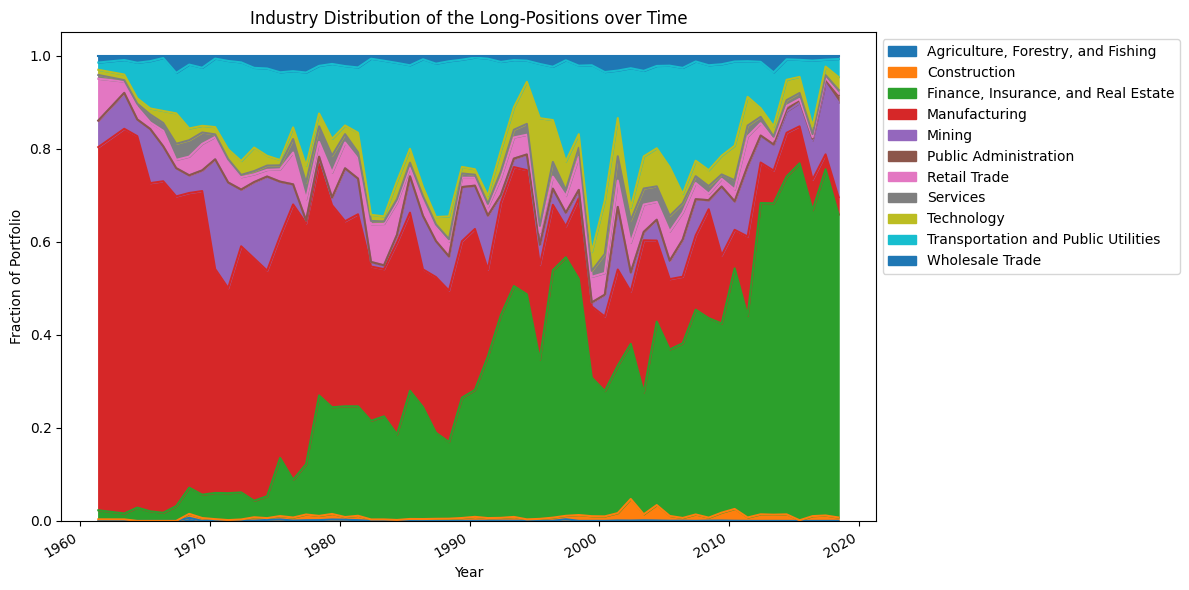

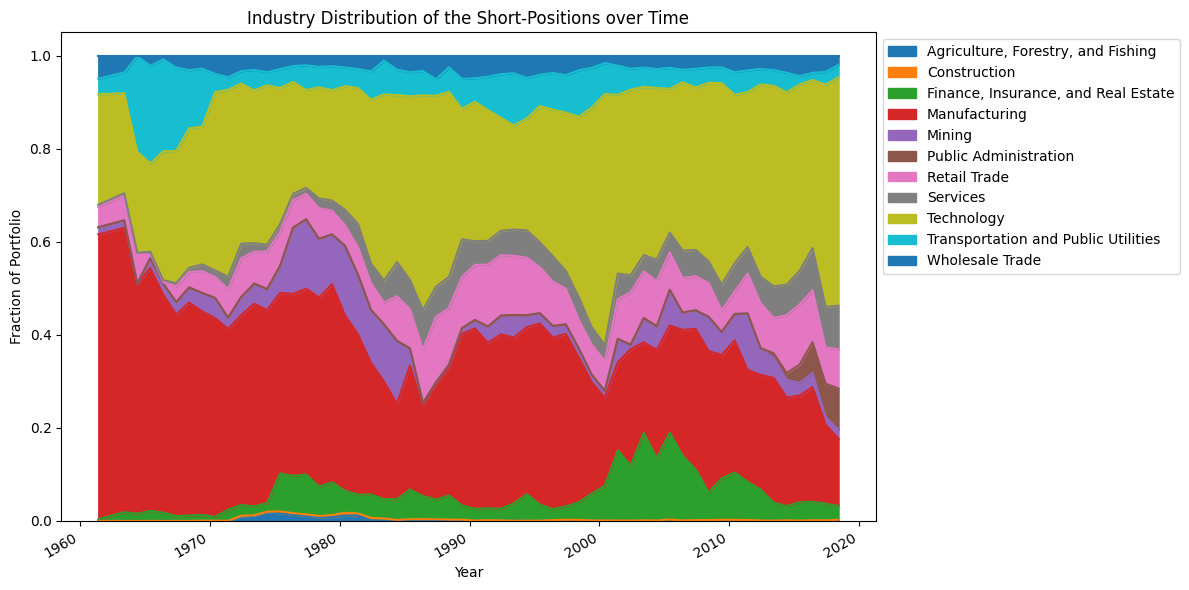

In [55]:
#Industry Analysis and HHI
df_industry_long = df.merge(df_top_permno_all, on=["date", "permno"], how="inner")
df_industry_short = df.merge(df_bottom_permno_all, on=["date", "permno"], how="inner")
df_industry_short = df_industry_short.dropna(subset=["hsiccd"])
df_industry_long = df_industry_long.dropna(subset=["hsiccd"])


def map_sic_to_sector(sic):
    sic_str = str(int(sic)).zfill(4)
    sic2 = int(sic_str[:2])

    technology_ranges = [
        (3570, 3579),  # Computer and Office equipment
        (3600, 3699),  # Electronics
        (7370, 7379),  # Software-Services
        (2830, 2839),  # Tech/Health
    ]

    sic4 = int(sic_str) 

    for start, end in technology_ranges:
        if start <= sic4 <= end:
            return "Technology"

    if 1 <= sic2 <= 9:
        return "Agriculture, Forestry, and Fishing"
    elif 10 <= sic2 <= 14:
        return "Mining"
    elif 15 <= sic2 <= 17:
        return "Construction"
    elif 20 <= sic2 <= 39:
        return "Manufacturing"
    elif 40 <= sic2 <= 49:
        return "Transportation and Public Utilities"
    elif 50 <= sic2 <= 51:
        return "Wholesale Trade"
    elif 52 <= sic2 <= 59:
        return "Retail Trade"
    elif 60 <= sic2 <= 67:
        return "Finance, Insurance, and Real Estate"
    elif 70 <= sic2 <= 89:
        return "Services"
    elif 90 <= sic2 <= 99:
        return "Public Administration"
    else:
        return "Other"


crsp = df.copy()
crsp['hsiccd'] = pd.to_numeric(crsp['hsiccd'], errors='coerce')  # convert to numeric, set errors to NaN
crsp = crsp.dropna(subset=['hsiccd'])  # remove rows with NaN SICCD

# Now safely convert to int
crsp['hsiccd'] = crsp['hsiccd'].astype(int)
crsp['industry'] = crsp['hsiccd'].apply(map_sic_to_sector)


df_industry_long["sector"] = df_industry_long["hsiccd"].apply(map_sic_to_sector)
grouped_long = df_industry_long.groupby(["date", "sector"])["market_equity"].sum().reset_index()
grouped_long["weight"] = grouped_long.groupby("date")["market_equity"].transform(lambda x: x / x.sum())

df_industry_short["sector"] = df_industry_short["hsiccd"].apply(map_sic_to_sector)
grouped_short = df_industry_short.groupby(["date", "sector"])["market_equity"].sum().reset_index()
grouped_short["weight"] = grouped_short.groupby("date")["market_equity"].transform(lambda x: x / x.sum())

pivot_df_long = grouped_long.pivot(index="date", columns="sector", values="weight")
pivot_df_short = grouped_short.pivot(index="date", columns="sector", values="weight")

pivot_df_long.plot.area(figsize=(12, 6))
plt.title("Industry Distribution of the Long-Positions over Time")
plt.ylabel("Fraction of Portfolio")
plt.xlabel("Year")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

pivot_df_short.plot.area(figsize=(12, 6))
plt.title("Industry Distribution of the Short-Positions over Time")
plt.ylabel("Fraction of Portfolio")
plt.xlabel("Year")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()



/var/folders/47/ztkg05vx2hbdgfnfn0bh1y3w0000gn/T/ipykernel_72357/2381470393.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


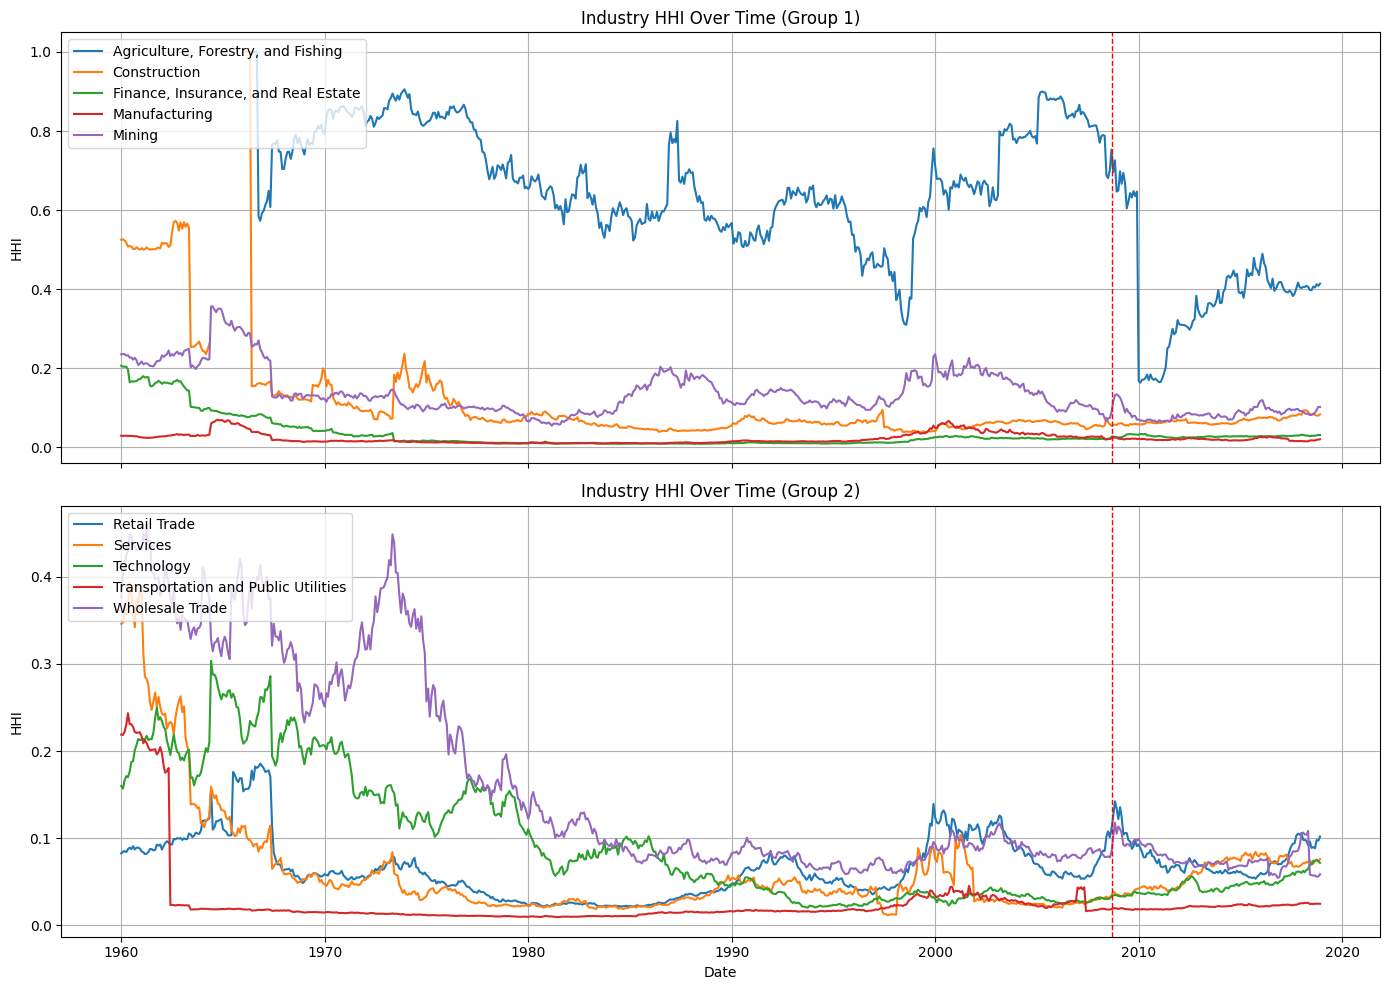

                               industry  HHI_compounded
0    Agriculture, Forestry, and Fishing     5806.432988
5                 Public Administration     1646.872227
4                                Mining      991.025855
10                      Wholesale Trade      626.782726
6                          Retail Trade      626.374102
1                          Construction      441.603136
7                              Services      330.590508
8                            Technology      271.037232
3                         Manufacturing      173.933608
2   Finance, Insurance, and Real Estate      170.921784
9   Transportation and Public Utilities      114.436516


In [ ]:
#HHI computation
# 1. Clean market cap
crsp['adj_price'] = crsp['adj_price'].abs()
crsp['MktCap'] = crsp['adj_price'] * crsp['adj_shrout']
crsp['MktCap'] = crsp['MktCap'] * 100

# 2. Filter valid data
crsp = crsp.dropna(subset=['MktCap', 'hsiccd'])

hhi_by_industry = (
    crsp
    .groupby(['date', 'industry'])
    .apply(lambda g: pd.Series({
        'HHI': ((g['MktCap'] / g['MktCap'].sum()) ** 2).sum(),
        'Industry_MktCap': g['MktCap'].sum()
    }))
    .reset_index()
)

import matplotlib.pyplot as plt
import pandas as pd

# Pivot to time series
hhi_ts = hhi_by_industry.pivot(index='date', columns='industry', values='HHI')

# Remove 'Public Administration' if present
if 'Public Administration' in hhi_ts.columns:
    hhi_ts = hhi_ts.drop(columns='Public Administration')

# Split industries alphabetically into two balanced groups
industries = sorted(hhi_ts.columns)
mid = len(industries) // 2
group1 = industries[:mid]
group2 = industries[mid:]

# Plot
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot Group 1
for col in group1:
    axes[0].plot(hhi_ts.index, hhi_ts[col], label=col)
axes[0].set_title('Industry HHI Over Time (Group 1)')
axes[0].set_ylabel('HHI')
axes[0].legend(loc='upper left')
axes[0].grid(True)
axes[0].axvline(pd.Timestamp('2008-09-15'), color='red', linestyle='--', linewidth=1, label='Lehman Collapse')

# Plot Group 2
for col in group2:
    axes[1].plot(hhi_ts.index, hhi_ts[col], label=col)
axes[1].set_title('Industry HHI Over Time (Group 2)')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('HHI')
axes[1].legend(loc='upper left')
axes[1].grid(True)
axes[1].axvline(pd.Timestamp('2008-09-15'), color='red', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

hhi_compounded = (
    crsp
    .groupby(['industry', 'permno'])['MktCap']
    .sum()
    .groupby(level=0)
    .apply(lambda x: (((x / x.sum())*100) ** 2).sum())
    .reset_index(name='HHI_compounded')
)

# Sort for easy comparison
hhi_compounded = hhi_compounded.sort_values('HHI_compounded', ascending=False)
print(hhi_compounded)

Processing year 1961...
  Calculating returns for 1961-07...
    Long: 0.0124 (122 stocks)
    Short: 0.0151 (121 stocks)
    Spread: -0.0027
  Calculating returns for 1961-08...
    Long: 0.0311 (123 stocks)
    Short: 0.0191 (121 stocks)
    Spread: 0.0120
  Calculating returns for 1961-09...
    Long: -0.0325 (123 stocks)
    Short: -0.0310 (121 stocks)
    Spread: -0.0015
  Calculating returns for 1961-10...
    Long: 0.0154 (123 stocks)
    Short: 0.0214 (122 stocks)
    Spread: -0.0060
  Calculating returns for 1961-11...
    Long: 0.0416 (123 stocks)
    Short: 0.0520 (122 stocks)
    Spread: -0.0104
  Calculating returns for 1961-12...
    Long: -0.0046 (123 stocks)
    Short: 0.0100 (122 stocks)
    Spread: -0.0147
  Calculating returns for 1962-01...
    Long: -0.0433 (123 stocks)
    Short: -0.0026 (122 stocks)
    Spread: -0.0407
  Calculating returns for 1962-02...
    Long: 0.0102 (123 stocks)
    Short: 0.0133 (122 stocks)
    Spread: -0.0031
  Calculating returns for 19

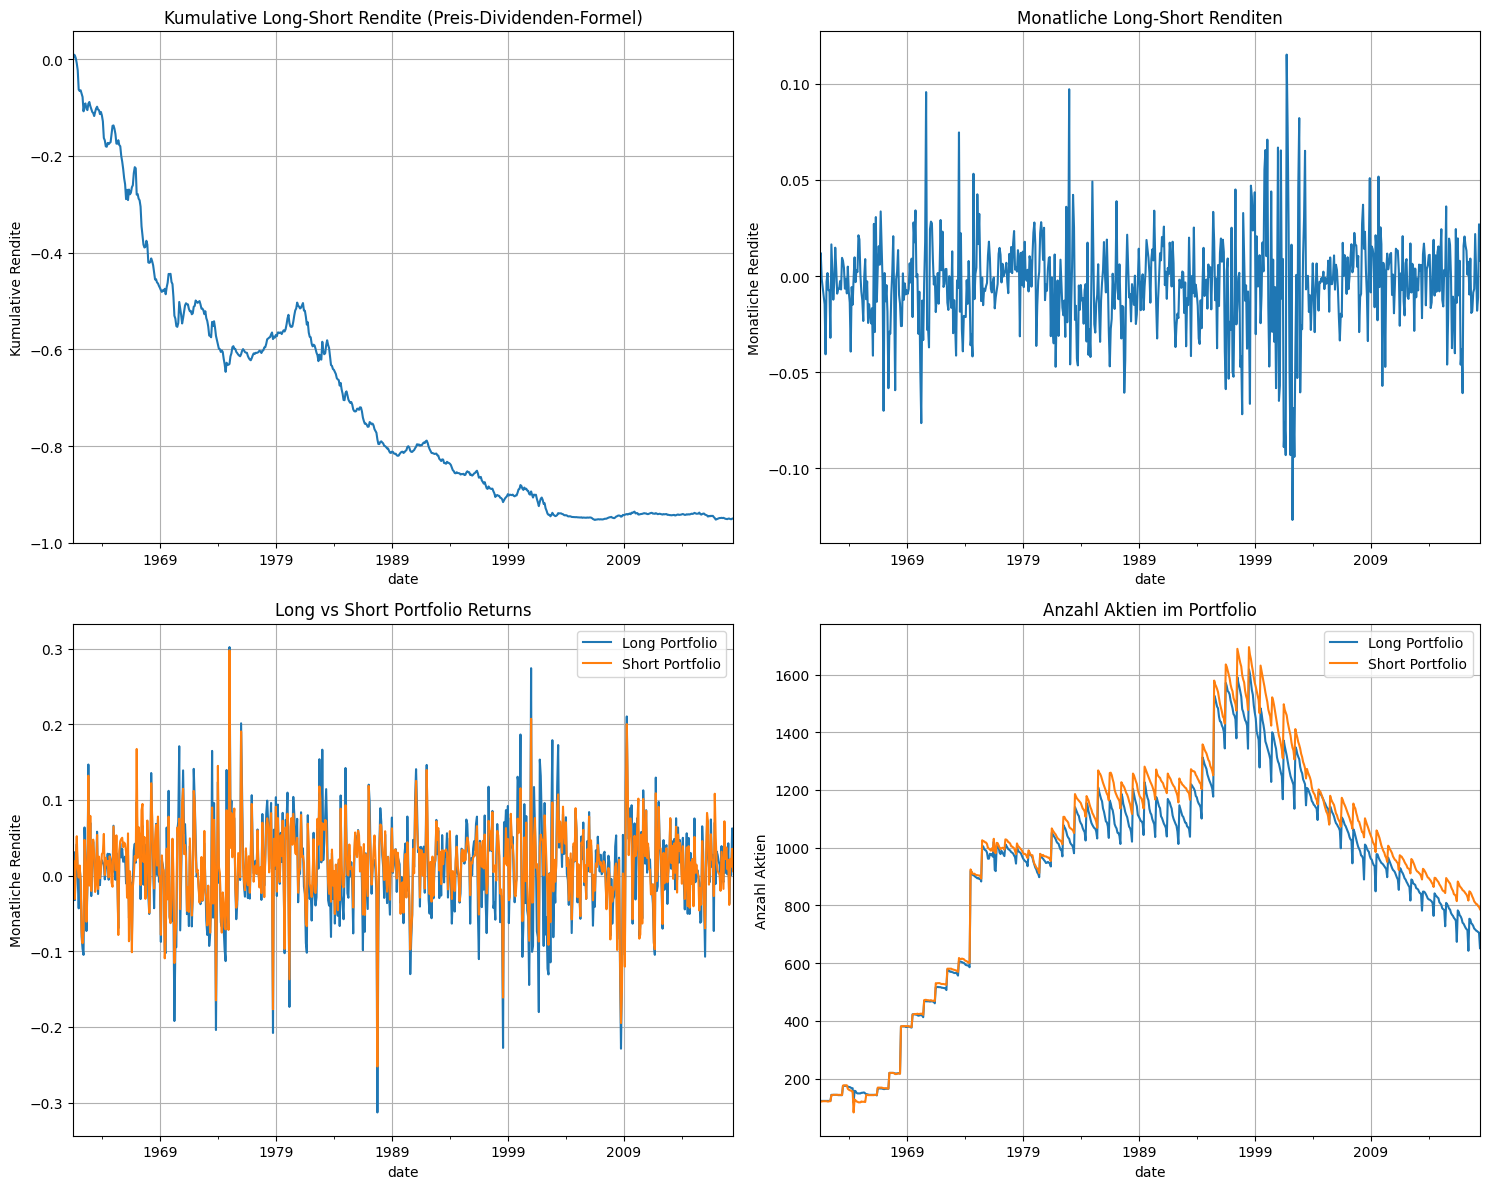


=== DIAGNOSE ===
Letzte 10 Renditen:
            long_return  short_return  long_short_return
date                                                    
2017-09-30     0.052447      0.071693          -0.019246
2017-10-31     0.003577      0.021990          -0.018413
2017-11-30     0.028396      0.036985          -0.008589
2017-12-31     0.001691      0.008386          -0.006695
2018-01-31     0.042618      0.020771           0.021847
2018-02-28    -0.037385     -0.038845           0.001459
2018-03-31     0.003969      0.022017          -0.018048
2018-04-30     0.000477      0.011687          -0.011210
2018-05-31     0.062321      0.035392           0.026929
2018-06-30     0.013637      0.005720           0.007917

Anzahl extremer Renditen (>20%): 0

Ergebnisse gespeichert in 'long_short_returns_clean.csv'


In [78]:
# VOLLSTÄNDIGE RENDITEBERECHNUNG ÜBER PREIS-DIVIDENDEN-FORMEL
# Formel: R_t = (P_t + D_t) / P_{t-1} - 1

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Initialisierung der Listen für Equal Weight Berechnung
monthly_returns_long_ew = []
monthly_returns_short_ew = []
long_short_returns_clean = []

# Tracking für Portfolios über die Zeit
portfolio_tracking = []

for year in sorted(set(date.year for date in bm_dec.index)):
    
    date = pd.Timestamp(f"{year}-06")
    date_dec = pd.Timestamp(f"{year-1}-12")
    
    if date_dec not in bm_dec.index:
        continue
    if year == 2018:  # Daten enden 2018
        continue
    
    # Zeitrahmen: Juli des aktuellen Jahres bis Juni des folgenden Jahres
    month_range = pd.date_range(start=date + pd.DateOffset(months=1), periods=12, freq="ME")
    
    print(f"Processing year {year}...")
    
    # STOCK SELECTION (gleich wie vorher)
    clean_row = bm_dec.loc[date_dec].dropna().sort_values(ascending=True)
    n = len(clean_row)
    if n == 0:
        continue
        
    k = int(n * 0.3)
    low_bm_permnos = clean_row.iloc[:k].index.tolist()   # Niedrige BM (Short)
    high_bm_permnos = clean_row.iloc[-k:].index.tolist() # Hohe BM (Long)
    
    # Speichere Portfolio-Zusammensetzung
    portfolio_tracking.append({
        'year': year,
        'rebalance_date': date,
        'high_bm_stocks': len(high_bm_permnos),
        'low_bm_stocks': len(low_bm_permnos)
    })
    
    # MONATLICHE RENDITEBERECHNUNG über Preis-Dividenden-Formel
    for i, current_month in enumerate(month_range):
        
        current_date = current_month
        
        # Bestimme vorherigen Monat
        if i == 0:
            # Erster Monat: verwende Rebalancing-Datum als Basis
            previous_date = date
        else:
            previous_date = month_range[i-1]
        
        print(f"  Calculating returns for {current_date.strftime('%Y-%m')}...")
        
        # === LONG PORTFOLIO (High BM) ===
        individual_returns_long = []
        
        for permno in high_bm_permnos:
            try:
                # Aktuelle Preise und Dividenden
                if current_date in price.index and permno in price.columns:
                    P_t = price.loc[current_date, permno]
                else:
                    continue
                    
                if previous_date in price.index and permno in price.columns:
                    P_t_minus_1 = price.loc[previous_date, permno]
                else:
                    continue
                
                # Dividenden für den aktuellen Monat
                if current_date in dividends.index and permno in dividends.columns:
                    D_t = dividends.loc[current_date, permno]
                    if pd.isna(D_t):
                        D_t = 0
                else:
                    D_t = 0
                
                # Prüfe auf gültige Werte
                if pd.isna(P_t) or pd.isna(P_t_minus_1) or P_t_minus_1 <= 0:
                    continue
                
                # RENDITEBERECHNUNG: R = (P_t + D_t) / P_{t-1} - 1
                stock_return = (P_t + D_t) / P_t_minus_1 - 1
                
                # Sanity Check: Extreme Renditen ausschließen
                if -0.95 <= stock_return <= 5.0:  # Zwischen -95% und +500%
                    individual_returns_long.append(stock_return)
                    
            except Exception as e:
                continue
        
        # === SHORT PORTFOLIO (Low BM) ===
        individual_returns_short = []
        
        for permno in low_bm_permnos:
            try:
                # Aktuelle Preise und Dividenden
                if current_date in price.index and permno in price.columns:
                    P_t = price.loc[current_date, permno]
                else:
                    continue
                    
                if previous_date in price.index and permno in price.columns:
                    P_t_minus_1 = price.loc[previous_date, permno]
                else:
                    continue
                
                # Dividenden für den aktuellen Monat
                if current_date in dividends.index and permno in dividends.columns:
                    D_t = dividends.loc[current_date, permno]
                    if pd.isna(D_t):
                        D_t = 0
                else:
                    D_t = 0
                
                # Prüfe auf gültige Werte
                if pd.isna(P_t) or pd.isna(P_t_minus_1) or P_t_minus_1 <= 0:
                    continue
                
                # RENDITEBERECHNUNG: R = (P_t + D_t) / P_{t-1} - 1
                stock_return = (P_t + D_t) / P_t_minus_1 - 1
                
                # Sanity Check: Extreme Renditen ausschließen
                if -0.95 <= stock_return <= 5.0:  # Zwischen -95% und +500%
                    individual_returns_short.append(stock_return)
                    
            except Exception as e:
                continue
        
        # EQUAL WEIGHT Portfolio-Renditen berechnen
        if len(individual_returns_long) > 0:
            portfolio_return_long = np.mean(individual_returns_long)
            monthly_returns_long_ew.append({
                'date': current_date,
                'return': portfolio_return_long,
                'n_stocks': len(individual_returns_long)
            })
        else:
            portfolio_return_long = np.nan
            
        if len(individual_returns_short) > 0:
            portfolio_return_short = np.mean(individual_returns_short)
            monthly_returns_short_ew.append({
                'date': current_date,
                'return': portfolio_return_short,
                'n_stocks': len(individual_returns_short)
            })
        else:
            portfolio_return_short = np.nan
        
        # LONG-SHORT SPREAD berechnen
        if not pd.isna(portfolio_return_long) and not pd.isna(portfolio_return_short):
            long_short_spread = portfolio_return_long - portfolio_return_short
            long_short_returns_clean.append({
                'date': current_date,
                'long_return': portfolio_return_long,
                'short_return': portfolio_return_short,
                'long_short_return': long_short_spread,
                'long_stocks': len(individual_returns_long),
                'short_stocks': len(individual_returns_short)
            })
            
            print(f"    Long: {portfolio_return_long:.4f} ({len(individual_returns_long)} stocks)")
            print(f"    Short: {portfolio_return_short:.4f} ({len(individual_returns_short)} stocks)")
            print(f"    Spread: {long_short_spread:.4f}")

# ERGEBNISSE ZUSAMMENFASSEN
print("\n=== CREATING FINAL DATAFRAMES ===")

# Long-Short Returns DataFrame
df_ls_clean = pd.DataFrame(long_short_returns_clean)
if not df_ls_clean.empty:
    df_ls_clean.set_index('date', inplace=True)
    df_ls_clean['cumulative_return'] = (1 + df_ls_clean['long_short_return']).cumprod() - 1

# Portfolio Tracking
df_portfolio = pd.DataFrame(portfolio_tracking)

# STATISTIKEN und PLOTS
if not df_ls_clean.empty:
    print("\n=== FINAL STATISTICS ===")
    print(f"Zeitraum: {df_ls_clean.index.min()} bis {df_ls_clean.index.max()}")
    print(f"Anzahl Monate: {len(df_ls_clean)}")
    print(f"Durchschnittliche monatliche Rendite: {df_ls_clean['long_short_return'].mean():.4f}")
    print(f"Annualisierte Rendite: {df_ls_clean['long_short_return'].mean() * 12:.4f}")
    print(f"Volatilität (monatlich): {df_ls_clean['long_short_return'].std():.4f}")
    print(f"Volatilität (annualisiert): {df_ls_clean['long_short_return'].std() * np.sqrt(12):.4f}")
    print(f"Sharpe Ratio: {(df_ls_clean['long_short_return'].mean() * 12) / (df_ls_clean['long_short_return'].std() * np.sqrt(12)):.4f}")
    print(f"Gesamtrendite: {df_ls_clean['cumulative_return'].iloc[-1]:.4f}")
    print(f"Durchschnittliche Anzahl Long-Aktien: {df_ls_clean['long_stocks'].mean():.1f}")
    print(f"Durchschnittliche Anzahl Short-Aktien: {df_ls_clean['short_stocks'].mean():.1f}")
    
    # PLOTS
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Kumulative Rendite
    df_ls_clean['cumulative_return'].plot(ax=ax1, title="Kumulative Long-Short Rendite (Preis-Dividenden-Formel)")
    ax1.set_ylabel("Kumulative Rendite")
    ax1.grid(True)
    
    # 2. Monatliche Renditen
    df_ls_clean['long_short_return'].plot(ax=ax2, title="Monatliche Long-Short Renditen")
    ax2.set_ylabel("Monatliche Rendite")
    ax2.grid(True)
    
    # 3. Long vs Short Performance
    df_ls_clean[['long_return', 'short_return']].plot(ax=ax3, title="Long vs Short Portfolio Returns")
    ax3.set_ylabel("Monatliche Rendite")
    ax3.legend(['Long Portfolio', 'Short Portfolio'])
    ax3.grid(True)
    
    # 4. Anzahl Aktien im Portfolio
    df_ls_clean[['long_stocks', 'short_stocks']].plot(ax=ax4, title="Anzahl Aktien im Portfolio")
    ax4.set_ylabel("Anzahl Aktien")
    ax4.legend(['Long Portfolio', 'Short Portfolio'])
    ax4.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Zusätzliche Diagnose
    print("\n=== DIAGNOSE ===")
    print("Letzte 10 Renditen:")
    print(df_ls_clean[['long_return', 'short_return', 'long_short_return']].tail(10))
    
    extreme_returns = df_ls_clean[(df_ls_clean['long_short_return'].abs() > 0.2)]
    print(f"\nAnzahl extremer Renditen (>20%): {len(extreme_returns)}")
    if len(extreme_returns) > 0:
        print("Extreme Renditen:")
        print(extreme_returns[['long_return', 'short_return', 'long_short_return']])

else:
    print("FEHLER: Keine gültigen Daten gefunden!")

# Speichere Ergebnisse für weitere Analyse
df_ls_clean.to_csv('long_short_returns_clean.csv')
print(f"\nErgebnisse gespeichert in 'long_short_returns_clean.csv'")

=== CREATING FAMA-FRENCH HML FACTOR ===
=== FAMA-FRENCH HML CONSTRUCTION ===
Exchanges included: [1]
  - NYSE
Processing year 1962...
  Size median: 82041000.00
  B/M breakpoints: -0.6228 (30th), 0.0917 (70th)
  Portfolio SL: 34 stocks
  Portfolio SM: 96 stocks
  Portfolio SH: 110 stocks
  Portfolio BL: 110 stocks
  Portfolio BM: 95 stocks
  Portfolio BH: 34 stocks
    1962-07: HML = -0.0082 (V=0.0619, G=0.0701)
    1962-08: HML = 0.0118 (V=0.0291, G=0.0172)
    1962-09: HML = 0.0180 (V=-0.0552, G=-0.0733)
    1962-10: HML = 0.0087 (V=-0.0176, G=-0.0264)
    1962-11: HML = -0.0172 (V=0.1319, G=0.1491)
    1962-12: HML = 0.0094 (V=-0.0043, G=-0.0137)
    1963-01: HML = 0.0144 (V=0.0888, G=0.0744)
    1963-02: HML = 0.0323 (V=0.0017, G=-0.0306)
    1963-03: HML = 0.0102 (V=0.0285, G=0.0183)
    1963-04: HML = 0.0036 (V=0.0419, G=0.0383)
    1963-05: HML = 0.0227 (V=0.0459, G=0.0232)
    1963-06: HML = -0.0088 (V=-0.0207, G=-0.0118)
Processing year 1963...
  Size median: 121769375.00
  B/

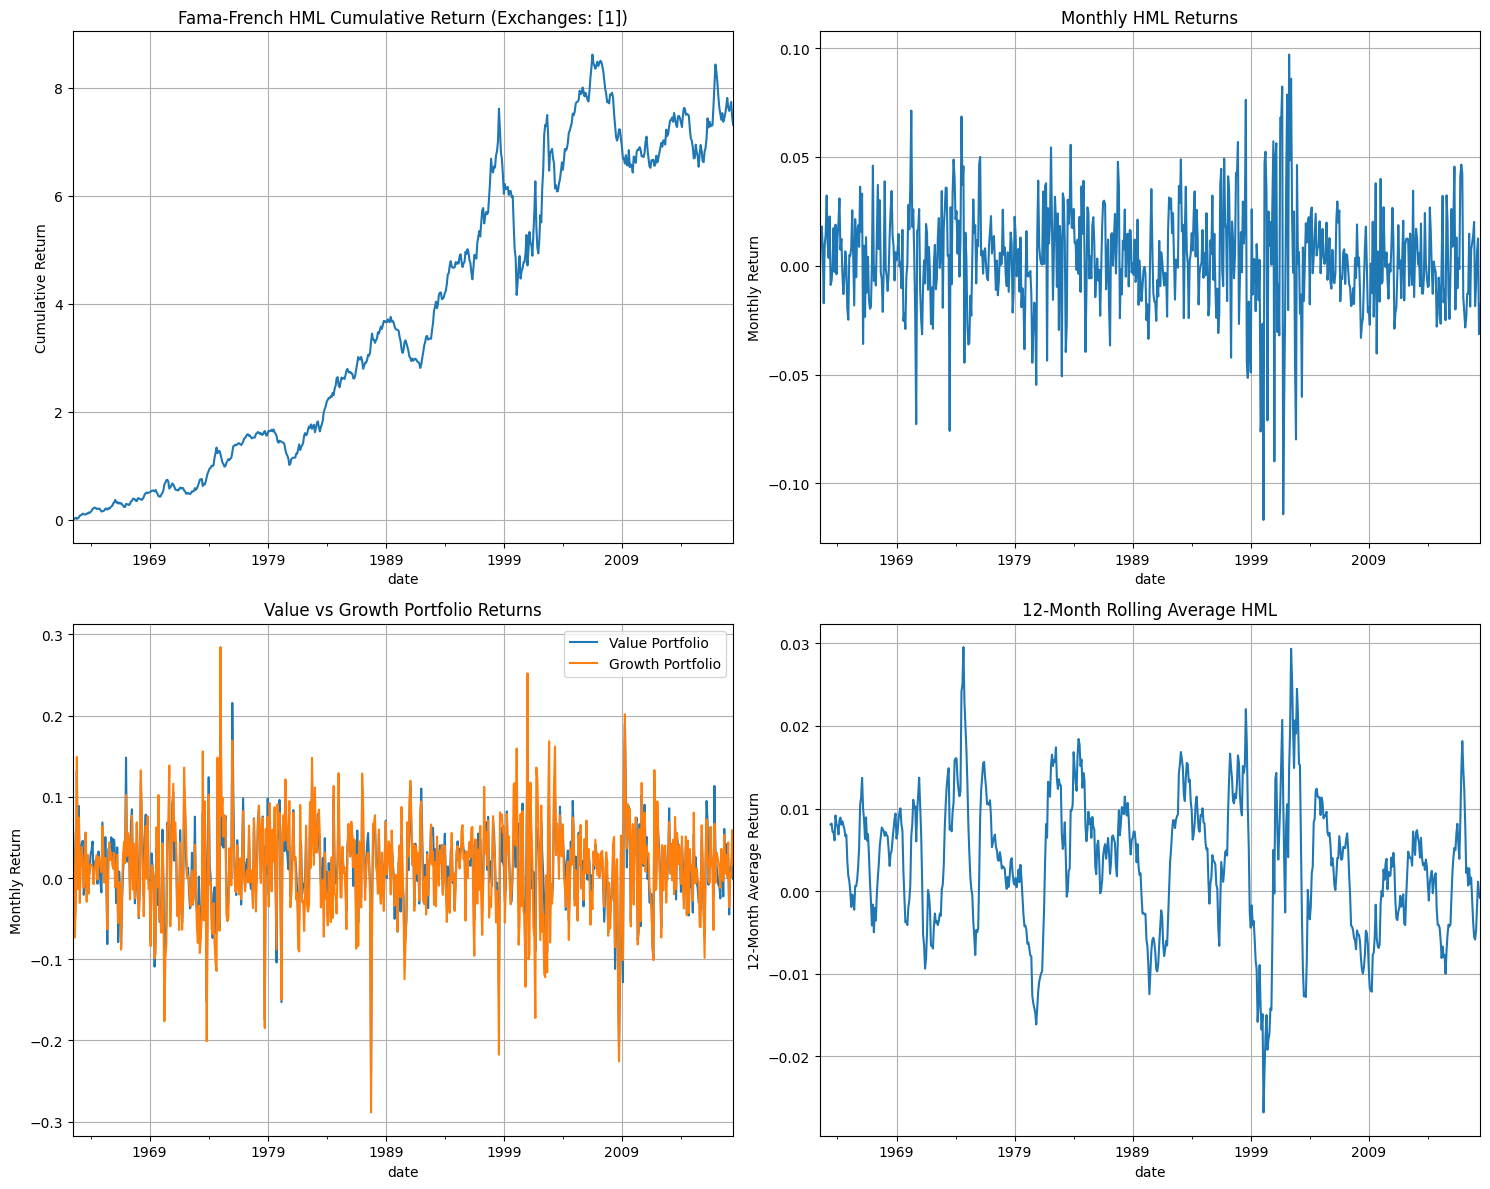


Results saved with exchange suffix: [1]

=== DIAGNOSTIC INFO ===
Sample portfolio details:
   year  total_stocks  total_delistings
0  1962           479                 0
1  1963           575                 0
2  1964           417                 0
3  1965           408                 0
4  1966           449                 0

First few months of returns:
            hml_return  value_return  growth_return
date                                               
1962-07-31   -0.008225      0.061897       0.070122
1962-08-31    0.011839      0.029060       0.017221
1962-09-30    0.018033     -0.055222      -0.073255
1962-10-31    0.008743     -0.017635      -0.026378
1962-11-30   -0.017226      0.131916       0.149142
1962-12-31    0.009362     -0.004310      -0.013672
1963-01-31    0.014403      0.088850       0.074447
1963-02-28    0.032267      0.001683      -0.030584
1963-03-31    0.010216      0.028534       0.018318
1963-04-30    0.003550      0.041877       0.038326

TO TEST DIFFE

In [157]:
# FAMA-FRENCH 2x3 SORT HML IMPLEMENTATION
# Standard methodology: Size x Book-to-Market sorts with delisting handling

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Main function to create Fama-French HML factor
def create_fama_french_hml(df, price, dividends, bm_data, me_data=None, exchanges=[1]):
    """
    Create HML factor using standard Fama-French 2x3 sort methodology
    
    Parameters:
    df: Main dataframe with company data
    price: Price data (wide format: dates x permnos)
    dividends: Dividend data (wide format: dates x permnos) 
    bm_data: Book-to-market data (wide format: dates x permnos)
    me_data: Market equity data (if None, will calculate from price and shares)
    exchanges: List of exchange codes to include (default=[1] for NYSE only)
               1=NYSE, 2=AMEX, 3=NASDAQ
    """
    
    print(f"=== FAMA-FRENCH HML CONSTRUCTION ===")
    print(f"Exchanges included: {exchanges}")
    if 1 in exchanges: print("  - NYSE")
    if 2 in exchanges: print("  - AMEX") 
    if 3 in exchanges: print("  - NASDAQ")
    
    hml_returns = []
    portfolio_details = []
    delisting_stats = []
    
    for year in sorted(set(date.year for date in bm_data.index)):
        
        if year < 1962 or year >= 2018:  # Adjust range as needed
            continue
            
        print(f"Processing year {year}...")
        
        # Dates for portfolio formation - using pd.to_datetime for proper format
        formation_date = pd.to_datetime(f"{year}-06-01")  # June of year t
        bm_date = pd.to_datetime(f"{year-1}-10-01")       # October of year t-1 (when B/M updated)
        me_date = pd.to_datetime(f"{year}-06-01")         # June of year t (market equity for size)
        
        # Check if we have the required data
        if bm_date not in bm_data.index:
            print(f"  Missing B/M data for {bm_date}")
            continue
            
        if formation_date not in price.index:
            print(f"  Missing price data for {formation_date}")
            continue
        
        # Step 1: Get Book-to-Market ratios from October
        bm_ratios = bm_data.loc[bm_date].dropna()
        
        # Step 2: Calculate Market Equity (ME) for June
        if me_data is not None and me_date in me_data.index:
            market_equity = me_data.loc[me_date].dropna()
        else:
            # Calculate ME from price and shares outstanding
            prices_june = price.loc[me_date].dropna()
            
            # Get shares outstanding for June
            shares_data = df[df['date'] == me_date].set_index('permno')['adj_shrout'] * 1000
            
            # Calculate market equity
            market_equity = prices_june * shares_data.reindex(prices_june.index)
            market_equity = market_equity.dropna()
        
        # Step 3: Find common stocks (intersection of B/M and ME data)
        common_stocks = bm_ratios.index.intersection(market_equity.index)
        
        if len(common_stocks) < 100:  # Minimum threshold
            print(f"  Insufficient stocks ({len(common_stocks)}) for year {year}")
            continue
            
        # Filter data to common stocks
        bm_common = bm_ratios.loc[common_stocks]
        me_common = market_equity.loc[common_stocks]
        
        # Step 4: Filter universe to selected exchanges and create breakpoints
        # Filter main universe to selected exchanges
        exchange_stocks = df[(df['date'] == me_date) & (df['exchcd'].isin(exchanges))]['permno'].values
        universe_common = [stock for stock in common_stocks if stock in exchange_stocks]
        
        if len(universe_common) < 100:  # Minimum threshold
            print(f"  Insufficient stocks in selected exchanges ({len(universe_common)})")
            continue
        
        # For breakpoints, always use NYSE stocks (standard FF methodology)
        nyse_stocks = df[(df['date'] == me_date) & (df['exchcd'] == 1)]['permno'].values
        nyse_common = [stock for stock in universe_common if stock in nyse_stocks]
        
        if len(nyse_common) < 50:  # Fallback to universe stocks if insufficient NYSE
            print(f"  Insufficient NYSE stocks for breakpoints, using all selected exchange stocks")
            nyse_common = universe_common
        
        # Size breakpoints (median of NYSE)
        nyse_me = me_common.loc[nyse_common]
        size_median = nyse_me.median()
        
        # B/M breakpoints (30th and 70th percentiles of NYSE)
        nyse_bm = bm_common.loc[nyse_common]
        bm_30 = nyse_bm.quantile(0.30)
        bm_70 = nyse_bm.quantile(0.70)
        
        print(f"  Size median: {size_median:.2f}")
        print(f"  B/M breakpoints: {bm_30:.4f} (30th), {bm_70:.4f} (70th)")
        
        # Step 5: Assign all stocks to 6 portfolios (2x3 sorts)
        portfolios = {
            'SL': [],  # Small Low B/M (Small Growth)
            'SM': [],  # Small Medium B/M  
            'SH': [],  # Small High B/M (Small Value)
            'BL': [],  # Big Low B/M (Big Growth)
            'BM': [],  # Big Medium B/M
            'BH': []   # Big High B/M (Big Value)
        }
        
        for stock in common_stocks:
            me_stock = me_common.loc[stock]
            bm_stock = bm_common.loc[stock]
            
            # Size classification
            if me_stock <= size_median:
                size_class = 'S'  # Small
            else:
                size_class = 'B'  # Big
            
            # B/M classification
            if bm_stock <= bm_30:
                bm_class = 'L'    # Low B/M (Growth)
            elif bm_stock <= bm_70:
                bm_class = 'M'    # Medium B/M
            else:
                bm_class = 'H'    # High B/M (Value)
            
            portfolio_key = size_class + bm_class
            portfolios[portfolio_key].append(stock)
        
        # Print portfolio sizes
        for key, stocks in portfolios.items():
            print(f"  Portfolio {key}: {len(stocks)} stocks")
        
        # Step 6: Calculate monthly returns for each portfolio with delisting handling
        month_range = pd.date_range(start=formation_date + pd.DateOffset(months=1), 
                                  periods=12, freq="ME")
        
        portfolio_returns = {key: [] for key in portfolios.keys()}
        monthly_delisting_count = []
        
        for current_month in month_range:
            current_date = current_month
            
            # Determine previous month for return calculation
            if current_month == month_range[0]:
                previous_date = formation_date
            else:
                previous_date = month_range[month_range.get_loc(current_month) - 1]
            
            month_delistings = 0
            
            # Calculate returns for each portfolio
            for portfolio_name, stock_list in portfolios.items():
                if len(stock_list) == 0:
                    portfolio_returns[portfolio_name].append(np.nan)
                    continue
                
                individual_returns = []
                
                for permno in stock_list:
                    try:
                        stock_return = None
                        
                        # First, check for delisting return
                        delisting_data = df[(df['permno'] == permno) & (df['date'] == current_date)]
                        
                        if not delisting_data.empty and not pd.isna(delisting_data['dlret'].iloc[0]):
                            # Stock was delisted - use delisting return
                            stock_return = delisting_data['dlret'].iloc[0]
                            month_delistings += 1
                            print(f"    Delisting: {permno} return = {stock_return:.4f}")
                        
                        else:
                            # Regular return calculation
                            if (current_date in price.index and permno in price.columns and
                                previous_date in price.index and permno in price.columns):
                                
                                P_t = price.loc[current_date, permno]
                                P_t_minus_1 = price.loc[previous_date, permno]
                                
                                if current_date in dividends.index and permno in dividends.columns:
                                    D_t = dividends.loc[current_date, permno]
                                    if pd.isna(D_t):
                                        D_t = 0
                                else:
                                    D_t = 0
                                
                                # Calculate regular return
                                if not pd.isna(P_t) and not pd.isna(P_t_minus_1) and P_t_minus_1 > 0:
                                    stock_return = (P_t + D_t) / P_t_minus_1 - 1
                        
                        # Add return if valid
                        if stock_return is not None:
                            # Sanity check for extreme returns
                            if -0.99 <= stock_return <= 10.0:  # Allow for some extreme delisting returns
                                individual_returns.append(stock_return)
                            else:
                                print(f"    Extreme return filtered: {permno} = {stock_return:.4f}")
                        
                    except Exception as e:
                        continue
                
                # Calculate equal-weighted portfolio return
                if len(individual_returns) > 0:
                    portfolio_return = np.mean(individual_returns)
                    portfolio_returns[portfolio_name].append(portfolio_return)
                else:
                    portfolio_returns[portfolio_name].append(np.nan)
            
            monthly_delisting_count.append(month_delistings)
            if month_delistings > 0:
                print(f"    {current_date.strftime('%Y-%m')}: {month_delistings} delistings")
        
        # Step 7: Calculate HML factor for this year
        # HML = 1/2 * (SH + BH) - 1/2 * (SL + BL)
        # Value portfolios: SH (Small High B/M) + BH (Big High B/M) 
        # Growth portfolios: SL (Small Low B/M) + BL (Big Low B/M)
        
        for i, month in enumerate(month_range):
            try:
                # Value portfolio return (average of Small Value and Big Value)
                value_return = np.nanmean([portfolio_returns['SH'][i], portfolio_returns['BH'][i]])
                
                # Growth portfolio return (average of Small Growth and Big Growth)  
                growth_return = np.nanmean([portfolio_returns['SL'][i], portfolio_returns['BL'][i]])
                
                # HML return
                if not pd.isna(value_return) and not pd.isna(growth_return):
                    hml_return = value_return - growth_return
                    
                    hml_returns.append({
                        'date': month,
                        'hml_return': hml_return,
                        'value_return': value_return,
                        'growth_return': growth_return,
                        'formation_year': year
                    })
                    
                    print(f"    {month.strftime('%Y-%m')}: HML = {hml_return:.4f} (V={value_return:.4f}, G={growth_return:.4f})")
                
            except Exception as e:
                print(f"    Error calculating HML for {month}: {str(e)}")
                continue
        
        # Store portfolio details with delisting info
        portfolio_details.append({
            'year': year,
            'formation_date': formation_date,
            'size_median': size_median,
            'bm_30': bm_30,
            'bm_70': bm_70,
            'total_stocks': len(universe_common),
            'nyse_stocks': len(nyse_common),
            'portfolio_sizes': {k: len(v) for k, v in portfolios.items()},
            'total_delistings': sum(monthly_delisting_count)
        })
        
        delisting_stats.append({
            'year': year,
            'total_delistings': sum(monthly_delisting_count),
            'monthly_delistings': monthly_delisting_count
        })
    
    return pd.DataFrame(hml_returns), pd.DataFrame(portfolio_details), pd.DataFrame(delisting_stats)

# Usage example with exchange selection:
print("=== CREATING FAMA-FRENCH HML FACTOR ===")

# Choose your exchange universe:
# [1] = NYSE only (most conservative, matches early FF papers)
# [1, 2] = NYSE + AMEX (standard FF approach)  
# [1, 2, 3] = NYSE + AMEX + NASDAQ (modern approach)

EXCHANGE_UNIVERSE = [1]  # Start with NYSE only

try:
    # Run the Fama-French methodology
    hml_df, portfolio_details_df, delisting_stats_df = create_fama_french_hml(
        df, price, dividends, bm_dec, exchanges=EXCHANGE_UNIVERSE
    )
    
    if not hml_df.empty:
        # Set date as index
        hml_df.set_index('date', inplace=True)
        
        # Calculate cumulative returns
        hml_df['cumulative_hml'] = (1 + hml_df['hml_return']).cumprod() - 1
        
        # Print statistics
        print("\n=== FAMA-FRENCH HML STATISTICS ===")
        print(f"Exchange universe: {EXCHANGE_UNIVERSE}")
        print(f"Sample period: {hml_df.index.min()} to {hml_df.index.max()}")
        print(f"Number of months: {len(hml_df)}")
        print(f"Average monthly HML return: {hml_df['hml_return'].mean():.4f}")
        print(f"Annualized HML return: {hml_df['hml_return'].mean() * 12:.4f}")
        print(f"Monthly volatility: {hml_df['hml_return'].std():.4f}")
        print(f"Annualized volatility: {hml_df['hml_return'].std() * np.sqrt(12):.4f}")
        print(f"Sharpe ratio: {(hml_df['hml_return'].mean() * 12) / (hml_df['hml_return'].std() * np.sqrt(12)):.4f}")
        print(f"Total cumulative return: {hml_df['cumulative_hml'].iloc[-1]:.4f}")
        
        # Delisting statistics
        total_delistings = delisting_stats_df['total_delistings'].sum()
        print(f"\nTotal delistings over period: {total_delistings}")
        print(f"Average delistings per year: {total_delistings / len(delisting_stats_df):.1f}")
        
        # Period breakdown
        print("\n=== PERIOD BREAKDOWN ===")
        try:
            print(f"1960s average HML: {hml_df['1960':'1969']['hml_return'].mean() * 12:.4f}")
            print(f"1970s average HML: {hml_df['1970':'1979']['hml_return'].mean() * 12:.4f}")
            print(f"1980s average HML: {hml_df['1980':'1989']['hml_return'].mean() * 12:.4f}")
            print(f"1990s average HML: {hml_df['1990':'1999']['hml_return'].mean() * 12:.4f}")
            print(f"2000s average HML: {hml_df['2000':'2009']['hml_return'].mean() * 12:.4f}")
            print(f"2010s average HML: {hml_df['2010':'2018']['hml_return'].mean() * 12:.4f}")
        except:
            print("Could not calculate period breakdown")
        
        # Create plots
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        # Cumulative HML
        hml_df['cumulative_hml'].plot(ax=ax1, title=f"Fama-French HML Cumulative Return (Exchanges: {EXCHANGE_UNIVERSE})")
        ax1.set_ylabel("Cumulative Return")
        ax1.grid(True)
        
        # Monthly HML returns
        hml_df['hml_return'].plot(ax=ax2, title="Monthly HML Returns")
        ax2.set_ylabel("Monthly Return")
        ax2.grid(True)
        
        # Value vs Growth
        hml_df[['value_return', 'growth_return']].plot(ax=ax3, title="Value vs Growth Portfolio Returns")
        ax3.set_ylabel("Monthly Return")
        ax3.legend(['Value Portfolio', 'Growth Portfolio'])
        ax3.grid(True)
        
        # Rolling 12-month HML returns
        hml_df['hml_return'].rolling(12).mean().plot(ax=ax4, title="12-Month Rolling Average HML")
        ax4.set_ylabel("12-Month Average Return")
        ax4.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        # Save results
        hml_df.to_csv(f'fama_french_hml_returns_ex{EXCHANGE_UNIVERSE}.csv')
        portfolio_details_df.to_csv(f'fama_french_portfolio_details_ex{EXCHANGE_UNIVERSE}.csv')
        delisting_stats_df.to_csv(f'fama_french_delisting_stats_ex{EXCHANGE_UNIVERSE}.csv')
        print(f"\nResults saved with exchange suffix: {EXCHANGE_UNIVERSE}")
        
        # Additional diagnostics
        print("\n=== DIAGNOSTIC INFO ===")
        print("Sample portfolio details:")
        print(portfolio_details_df[['year', 'total_stocks', 'total_delistings']].head())
        
        print("\nFirst few months of returns:")
        print(hml_df[['hml_return', 'value_return', 'growth_return']].head(10))
        
    else:
        print("ERROR: No HML data generated!")
        
except Exception as e:
    print(f"ERROR in Fama-French HML calculation: {str(e)}")
    import traceback
    traceback.print_exc()

# Test different exchange universes:
print("\n" + "="*50)
print("TO TEST DIFFERENT UNIVERSES, CHANGE EXCHANGE_UNIVERSE:")
print("EXCHANGE_UNIVERSE = [1]        # NYSE only")
print("EXCHANGE_UNIVERSE = [1, 2]     # NYSE + AMEX") 
print("EXCHANGE_UNIVERSE = [1, 2, 3]  # NYSE + AMEX + NASDAQ")
print("="*50)

In [163]:
hml_ret = hml_df['hml_return']
pd.to_pickle(hml_df, 'hml_df.pkl')
hml_df

,hml_return,value_return,growth_return,formation_year,cumulative_hml
date,,,,,
1962-07-31,-0.008225,0.061897,0.070122,1962,-0.008225
1962-08-31,0.011839,0.029060,0.017221,1962,0.003516
1962-09-30,0.018033,-0.055222,-0.073255,1962,0.021613
1962-10-31,0.008743,-0.017635,-0.026378,1962,0.030545
1962-11-30,-0.017226,0.131916,0.149142,1962,0.012792
...,...,...,...,...,...
2018-02-28,-0.008893,-0.044821,-0.035928,2017,7.570285
2018-03-31,0.006576,0.012841,0.006264,2017,7.626646
2018-04-30,0.012575,0.013590,0.001015,2017,7.735130


In [132]:
# Apply NaN handling: fill where appropriate, avoid dividing by 0 or log(0)
eps = 1e-6  # Small value to avoid log(0)

#df_price_long_ts = df_price_long_ts.replace(0, np.nan).fillna(method='ffill')
#df_bookvalue_long_ts = df_bookvalue_long_ts.replace(0, np.nan).fillna(method='ffill')
#df_dividends_long_ts = df_dividends_long_ts.fillna(0)
#df_price_minus_long_ts = df_price_minus_long_ts.replace(0, np.nan).fillna(method='ffill')
#df_bookvalue_minus_long_ts = df_bookvalue_minus_long_ts.replace(0, np.nan).fillna(method='ffill')

#df_price_short_ts = df_price_short_ts.replace(0, np.nan).fillna(method='ffill')
#df_bookvalue_short_ts = df_bookvalue_short_ts.replace(0, np.nan).fillna(method='ffill')
#df_dividends_short_ts = df_dividends_short_ts.fillna(0)
#df_price_minus_short_ts = df_price_minus_short_ts.replace(0, np.nan).fillna(method='ffill')
#df_bookvalue_minus_short_ts = df_bookvalue_minus_short_ts.replace(0, np.nan).fillna(method='ffill')

#Annual time series
df_price_long_annual = df_price_long_ts#[df_price_long_ts.index.month==6]
df_price_short_annual = df_price_short_ts#[df_price_short_ts.index.month==6]
df_bookvalue_long_annual = df_bookvalue_long_ts#[df_bookvalue_long_ts.index.month==6]
df_bookvalue_short_annual = df_bookvalue_short_ts#[df_bookvalue_short_ts.index.month==6]
df_dividends_short_annual = df_dividends_short_adj.resample('YE-JUN').sum()
df_dividends_long_annual = df_dividends_long_adj.resample('YE-JUN').sum()
df_bookvalue_minus_long_ts = df_bookvalue_minus_long_ts#[df_bookvalue_minus_long_ts.index.month==6]
df_bookvalue_minus_short_ts = df_bookvalue_minus_short_ts#[df_bookvalue_minus_short_ts.index.month==6]
df_div_m_long_annual = df_dividends_minus_long_monthly_adj.resample('YE-JUN').sum()
df_div_m_short_annual = df_dividends_minus_short_monthly_adj.resample('YE-JUN').sum()
df_price_minus_short_ts = df_price_minus_short_ts#[df_price_minus_short_ts.index.month==6]
df_price_minus_long_ts = df_price_minus_long_ts#[df_price_minus_long_ts.index.month==6]

df_price_long_annual.index = df_price_long_annual.index.to_period('M').to_timestamp('M')
df_price_short_annual.index = df_price_short_annual.index.to_period('M').to_timestamp('M')
df_bookvalue_long_annual.index = df_bookvalue_long_annual.index.to_period('M').to_timestamp('M')
df_bookvalue_short_annual.index = df_bookvalue_short_annual.index.to_period('M').to_timestamp('M')
df_bookvalue_minus_long_ts.index = df_bookvalue_minus_long_ts.index.to_period('M').to_timestamp('M')
df_div_m_long_annual.index = df_div_m_long_annual.index.to_period('M').to_timestamp('M')
df_bookvalue_minus_short_ts.index = df_bookvalue_minus_short_ts.index.to_period('M').to_timestamp('M')
df_div_m_short_annual.index = df_div_m_short_annual.index.to_period('M').to_timestamp('M')
df_price_minus_long_ts.index = df_price_minus_long_ts.index.to_period('M').to_timestamp('M')
df_price_minus_short_ts.index = df_price_minus_short_ts.index.to_period('M').to_timestamp('M')
df_dividends_short_annual.index = df_dividends_short_annual.index.to_period('M').to_timestamp('M')
df_dividends_long_annual.index = df_dividends_long_annual.index.to_period('M').to_timestamp('M')
df_ann_ret_long.index = df_ann_ret_long.index.to_period('M').to_timestamp('M')
df_ann_ret_short.index = df_ann_ret_short.index.to_period('M').to_timestamp('M')
df_price_long_monthly.index = df_price_long_monthly.index.to_period('M').to_timestamp('M')
df_price_short_monthly.index = df_price_short_monthly.index.to_period('M').to_timestamp('M')
df_price_minus_long_monthly.index = df_price_minus_long_monthly.index.to_period('M').to_timestamp('M')
df_price_minus_short_monthly.index = df_price_minus_short_monthly.index.to_period('M').to_timestamp('M')
df_dividends_minus_long_monthly_adj.index = df_dividends_minus_long_monthly_adj.index.to_period('M').to_timestamp('M')
df_dividends_minus_short_monthly_adj.index = df_dividends_minus_short_monthly_adj.index.to_period('M').to_timestamp('M')
df_bookvalue_long_monthly.index = df_bookvalue_long_monthly.index.to_period('M').to_timestamp('M')
df_bookvalue_short_monthly.index = df_bookvalue_short_monthly.index.to_period('M').to_timestamp('M')
df_bookvalue_minus_long_monthly.index = df_bookvalue_minus_long_monthly.index.to_period('M').to_timestamp('M')
df_bookvalue_minus_short_monthly.index = df_bookvalue_minus_short_monthly.index.to_period('M').to_timestamp('M')
df_dividends_minus_long_monthly.index = df_dividends_minus_long_monthly.index.to_period('M').to_timestamp('M')
df_dividends_minus_short_monthly.index = df_dividends_minus_short_monthly.index.to_period('M').to_timestamp('M')


df_price_long_annual = df_price_long_annual.fillna(method='ffill')
df_price_short_annual = df_price_short_annual.fillna(method='ffill')
df_bookvalue_long_annual = df_bookvalue_long_annual.fillna(method='ffill')
df_bookvalue_short_annual = df_bookvalue_short_annual.fillna(method='ffill')
df_dividends_long_annual = df_dividends_long_annual.fillna(method='ffill')
df_dividends_short_annual = df_dividends_short_annual.fillna(method='ffill')
df_div_m_long_annual = df_div_m_long_annual.fillna(method='ffill')
df_div_m_short_annual = df_div_m_short_annual.fillna(method='ffill')

#Annual Log Returns
ccret_long = np.log((df_price_minus_long_ts + df_div_m_long_annual)/df_price_long_annual.shift(1))
ccret_short = np.log((df_price_minus_short_ts + df_div_m_short_annual)/df_price_short_annual.shift(1))
ccret = ccret_long-ccret_short

"""#Test return computation
test_ret_long = (df_price_minus_long_ts + df_div_m_long_annual)/df_price_long_annual.shift(1) - 1
test_ret_short = (df_price_minus_short_ts + df_div_m_short_annual)/df_price_short_annual.shift(1) - 1
test_log_ret_long = np.log(1+test_ret_long)
test_log_ret_short = np.log(1+test_ret_short)
test_log_ret = test_log_ret_long - test_log_ret_short"""

log_ann_ret_long = np.log(1+df_ann_ret_long).dropna()
log_ann_ret_short = np.log(1+df_ann_ret_short).dropna()
log_ann_ret_ls = log_ann_ret_long['ann_ret_long']- log_ann_ret_short['ann_ret_short']

# Revaluation component (change in P/B ratio)
change_in_aggregate_valuation_long = np.log(df_price_long_annual / (df_bookvalue_long_annual + eps)) - \
                                     np.log(df_price_long_annual.shift(1) / (df_bookvalue_long_annual.shift(1) + eps))

change_in_aggregate_valuation_short = np.log((df_price_short_annual / df_bookvalue_short_annual + eps)) - \
                                      np.log((df_price_short_annual.shift(1) / df_bookvalue_short_annual.shift(1) + eps))

# Income Yield
income_yield_long = np.log((df_bookvalue_minus_long_ts / (df_bookvalue_long_annual.shift(1) + eps))) + \
                    np.log(1 + df_div_m_long_annual / (df_price_minus_long_ts + eps))


income_yield_short = np.log(df_bookvalue_minus_short_ts / (df_bookvalue_short_annual.shift(1) + eps)) + \
                     np.log(1 + df_div_m_short_annual / (df_price_minus_short_ts + eps))

# Migration component
migration_long = np.log(df_price_minus_long_ts / (df_bookvalue_minus_long_ts + eps)) - \
                 np.log((df_price_long_annual / (df_bookvalue_long_annual + eps)))

migration_short = np.log(df_price_minus_short_ts / (df_bookvalue_minus_short_ts + eps)) - \
                  np.log(df_price_short_annual / (df_bookvalue_short_annual + eps))

change_in_aggregate_valuation_ls = change_in_aggregate_valuation_long - change_in_aggregate_valuation_short
income_yield_ls = income_yield_long - income_yield_short
migration_ls = migration_long - migration_short

#Monthly Data for return drivers
change_in_aggregate_valuation_long_monthly = np.log(df_price_long_monthly['avg_value'] / (df_bookvalue_long_monthly['bookvalue'] + eps)) - \
                                            np.log(df_price_long_monthly['avg_value'].shift(1)/(df_bookvalue_long_monthly['bookvalue'].shift(1) + eps))
change_in_aggregate_valuation_short_monthly = np.log(df_price_short_monthly['avg_value'] / (df_bookvalue_short_monthly['bookvalue'] + eps)) - \
                                            np.log(df_price_short_monthly['avg_value'].shift(1)/(df_bookvalue_short_monthly['bookvalue'].shift(1) + eps))

income_yield_long_monthly = np.log(df_bookvalue_minus_long_monthly['bookvalue'] / (df_bookvalue_long_monthly['bookvalue'].shift(1) + eps)) + \
                            np.log(1+ df_dividends_minus_long_monthly['avg_value']/(df_price_minus_long_monthly['avg_value'] + eps))
income_yield_short_monthly = np.log(df_bookvalue_minus_short_monthly['bookvalue'] / (df_bookvalue_short_monthly['bookvalue'].shift(1) + eps)) + \
                            np.log(1+ df_dividends_minus_short_monthly['avg_value']/(df_price_minus_short_monthly['avg_value'] + eps))

migration_long_monthly = np.log(df_price_minus_long_monthly['avg_value'] / (df_bookvalue_minus_long_monthly['bookvalue'] + eps)) - \
                        np.log(df_price_long_monthly['avg_value']/(df_bookvalue_long_monthly['bookvalue'] + eps))
migration_short_monthly = np.log(df_price_minus_short_monthly['avg_value'] / (df_bookvalue_minus_short_monthly['bookvalue'] + eps)) - \
                        np.log(df_price_short_monthly['avg_value']/(df_bookvalue_short_monthly['bookvalue'] + eps))                        

change_in_aggregate_valuation_monthly = change_in_aggregate_valuation_long_monthly - change_in_aggregate_valuation_short_monthly
income_yield_monthly = (income_yield_long_monthly - income_yield_short_monthly).dropna()
migration_monthly = migration_long_monthly - migration_short_monthly
change_in_aggregate_valuation_monthly.name = 'CAV_m'
income_yield_monthly.name = 'Income_Yield_m'
migration_monthly.name = 'Migration_m'

# Compose components
revaluation_component = change_in_aggregate_valuation_ls
structural_component = income_yield_ls + migration_ls

return_decomposition = change_in_aggregate_valuation_ls + income_yield_ls + migration_ls
return_decomposition_long = change_in_aggregate_valuation_long + income_yield_long + migration_long

/var/folders/47/ztkg05vx2hbdgfnfn0bh1y3w0000gn/T/ipykernel_37098/479568452.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_price_long_annual = df_price_long_annual.fillna(method='ffill')
/var/folders/47/ztkg05vx2hbdgfnfn0bh1y3w0000gn/T/ipykernel_37098/479568452.py:59: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_price_short_annual = df_price_short_annual.fillna(method='ffill')
/var/folders/47/ztkg05vx2hbdgfnfn0bh1y3w0000gn/T/ipykernel_37098/479568452.py:60: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_bookvalue_long_annual = df_bookvalue_long_annual.fillna(method='ffill')
/var/folders/47/ztkg05vx2hbdgfnfn0bh1y3w0000gn/T/ipykernel_37098/479568452.py:61: FutureWarning: DataFrame.fillna with 'method' i

In [135]:
hml_df = pd.read_pickle('Data/hml_df.pkl')
return_decomposition_monthly = pd.concat([hml_df['hml_return'], migration_monthly, income_yield_monthly, change_in_aggregate_valuation_monthly], axis=1, join='inner')
#pd.to_pickle(return_decomposition_monthly, 'return_decomposition_monthly.pkl')

In [57]:
#pd.to_pickle(change_in_aggregate_valuation_ls, 'change_in_aggregate_valuation.pkl')
pd.to_pickle(income_yield_ls, 'income_yield.pkl')
#pd.to_pickle(migration_ls, 'migration.pkl')

In [2]:
import pandas as pd
hml_df = pd.read_pickle('Data/hml_df.pkl')
hml_df['hml_return']

date
1962-07-31   -0.008225
1962-08-31    0.011839
1962-09-30    0.018033
1962-10-31    0.008743
1962-11-30   -0.017226
                ...   
2018-02-28   -0.008893
2018-03-31    0.006576
2018-04-30    0.012575
2018-05-31   -0.031393
2018-06-30   -0.017673
Name: hml_return, Length: 672, dtype: float64

In [58]:
#decomposition rolling
change_in_aggregate_valuation_rolling = change_in_aggregate_valuation_ls.rolling(5).mean()
income_yield_rolling = income_yield_ls.rolling(5).mean()
migration_rolling = migration_ls.rolling(5).mean()

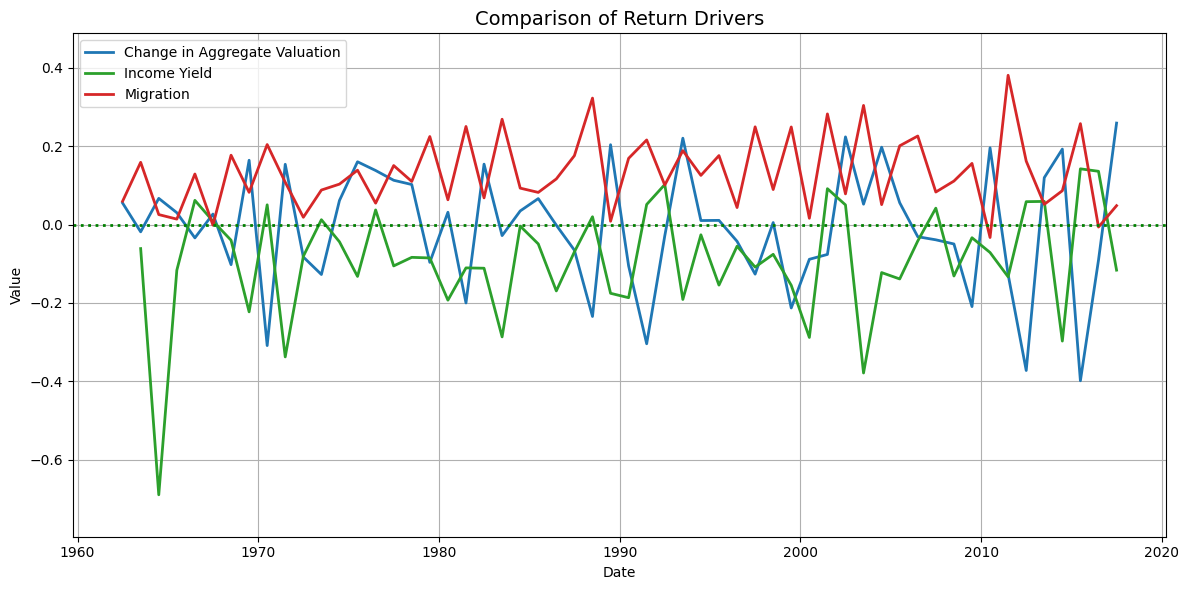

In [59]:
#Analysis of decomposed returns

plt.figure(figsize=(12, 6))

plt.plot(change_in_aggregate_valuation_ls.index, change_in_aggregate_valuation_ls, label='Change in Aggregate Valuation', color='tab:blue', linewidth=2)
plt.plot(income_yield_ls.index, income_yield_ls, label='Income Yield', color='tab:green', linewidth=2)
plt.plot(migration_ls.index, migration_ls, label='Migration', color='tab:red', linewidth=2)
plt.axhline(0, color='green', linewidth=2, linestyle=':')  # optional: add visible 0 line
plt.margins(y=0.1)
plt.title('Comparison of Return Drivers', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

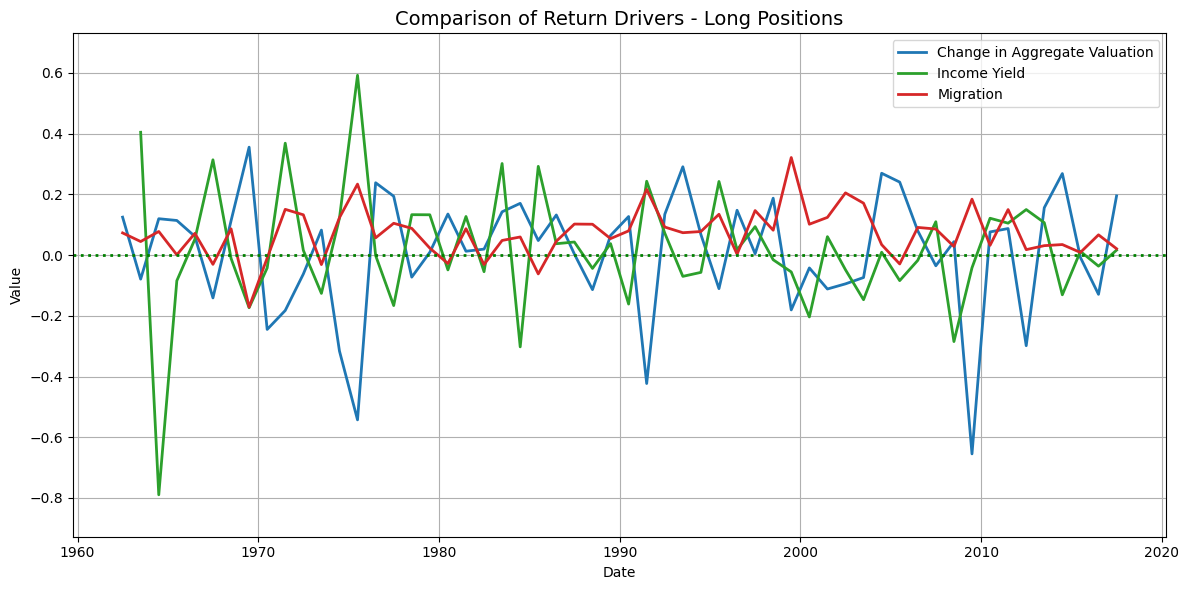

In [60]:
#Decomposition long
plt.figure(figsize=(12, 6))

plt.plot(change_in_aggregate_valuation_long.index, change_in_aggregate_valuation_long, label='Change in Aggregate Valuation', color='tab:blue', linewidth=2)
plt.plot(income_yield_long.index, income_yield_long, label='Income Yield', color='tab:green', linewidth=2)
plt.plot(migration_long.index, migration_long, label='Migration', color='tab:red', linewidth=2)
plt.axhline(0, color='green', linewidth=2, linestyle=':')  # optional: add visible 0 line
plt.margins(y=0.1)
plt.title('Comparison of Return Drivers - Long Positions', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

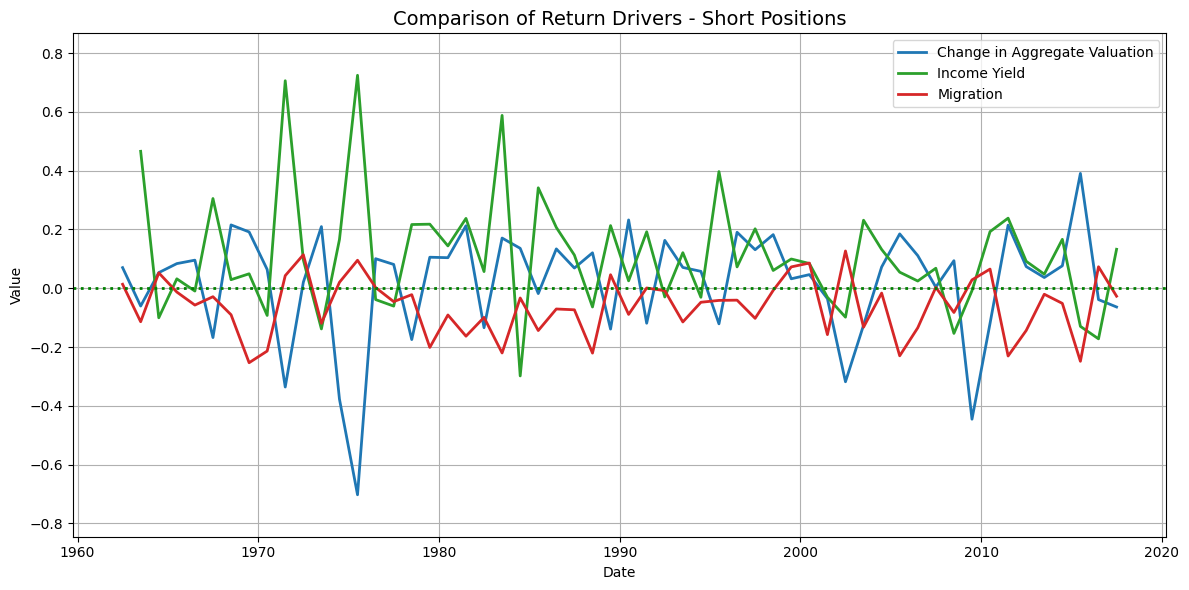

In [61]:
plt.figure(figsize=(12, 6))

plt.plot(change_in_aggregate_valuation_short.index, change_in_aggregate_valuation_short, label='Change in Aggregate Valuation', color='tab:blue', linewidth=2)
plt.plot(income_yield_short.index, income_yield_short, label='Income Yield', color='tab:green', linewidth=2)
plt.plot(migration_short.index, migration_short, label='Migration', color='tab:red', linewidth=2)
plt.axhline(0, color='green', linewidth=2, linestyle=':')  # optional: add visible 0 line
plt.margins(y=0.1)
plt.title('Comparison of Return Drivers - Short Positions', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

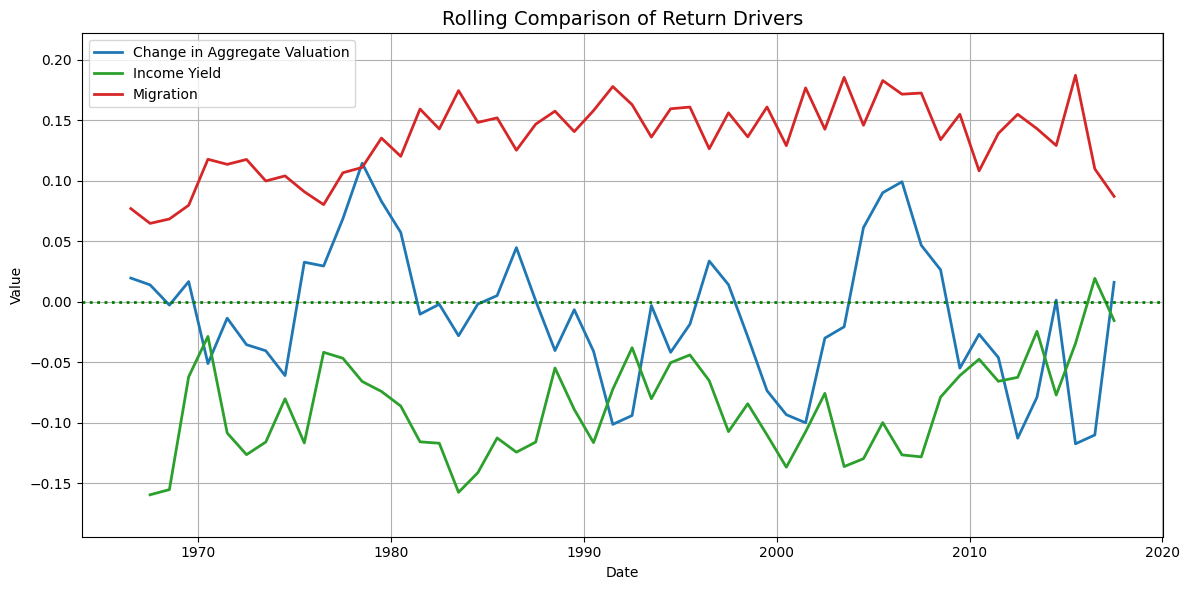

In [62]:
#Analysis of decomposed returns

plt.figure(figsize=(12, 6))

plt.plot(change_in_aggregate_valuation_rolling.index, change_in_aggregate_valuation_rolling, label='Change in Aggregate Valuation', color='tab:blue', linewidth=2)
plt.plot(income_yield_rolling.index, income_yield_rolling, label='Income Yield', color='tab:green', linewidth=2)
plt.plot(migration_rolling.index, migration_rolling, label='Migration', color='tab:red', linewidth=2)
plt.axhline(0, color='green', linewidth=2, linestyle=':')  # optional: add visible 0 line
plt.margins(y=0.1)
plt.title('Rolling Comparison of Return Drivers', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

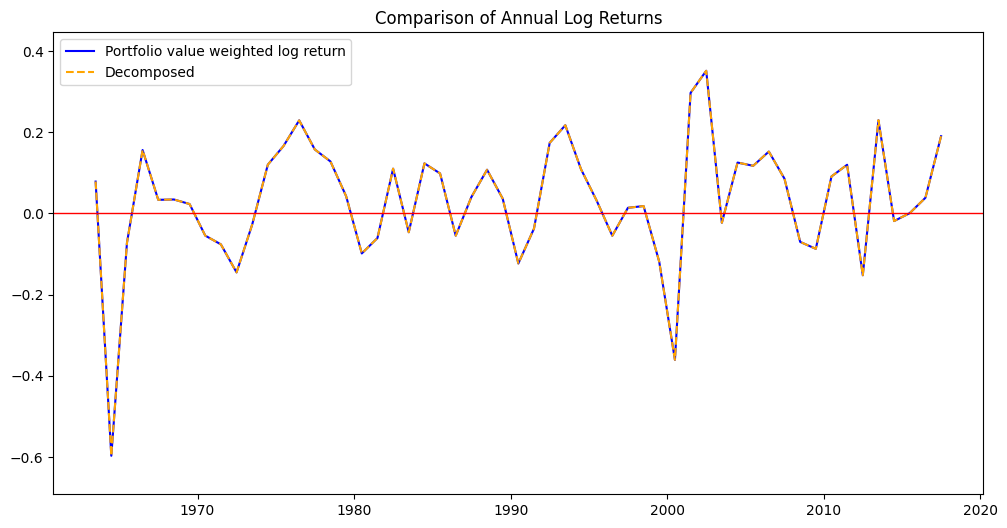

In [63]:
#Plot Return Comparios
plt.figure(figsize=(12, 6)) 
plt.plot(ccret.index, ccret, label="Portfolio value weighted log return", color="blue")
plt.plot(return_decomposition.index, return_decomposition, label="Decomposed", linestyle='--', color="orange")
plt.axhline(0, color='red', linewidth=1, linestyle='-')  # optional: add visible 0 line
plt.margins(y=0.1)
plt.legend()
plt.title("Comparison of Annual Log Returns")
plt.show()


deviations can come from:
- portfolio_log_returns annualization
- dividends_minus does not sum up all dividend payments in the year (only picks one month for evaluation)

The mistake that caused deviations between the original annual log return and the decomposed returns  (change in aggregate valuation, income yield and migration) was that the "normal" annualized log returns were value weighted while the decomposition was equally weighted. 

In [ ]:
"""pd.to_pickle(df_ls["long_short_ret"], "long_short_returns.pkl")
pd.to_pickle(long_ret, "price_long.pkl")
pd.to_pickle(portfolio_log_returns, "ls_log_ret.pkl")
pd.to_pickle(hhi_by_industry, 'HHI.pkl')
pd.to_pickle(etf_share, 'etf_share.pkl')"""
"""pd.to_pickle(df_price_long_annual, "price_long.pkl")
pd.to_pickle(df_bookvalue_short_annual, "bv_short.pkl")
pd.to_pickle(df_dividends_short_annual, "div_short.pkl")
pd.to_pickle(df_price_short_annual, 'price_short.pkl')
pd.to_pickle(df_bookvalue_long_annual, 'bv_long.pkl')
pd.to_pickle(df_dividends_long_annual, 'div_long.pkl')"""
#pd.to_pickle(ccret, "long_short_returns.pkl")